# **Sleep stages classification**
___

Our goal is to create a classifier that can classify sleep EEG data into sleep stages (AASM manual). This classifier will then be avalaible for anyone who have an OpenBCI. We will only use EEG data since it is the most prominent feature when doing sleep stage classification and also because we need to keep it simple for the end user.

# Dataset exploration
___

This notebooks aims to explore the dataset [sleep-edf](https://physionet.org/content/sleep-edfx/1.0.0/) of _physionet_. We're only using the sleep cassettes and here's what we should know about it:
```
The 153 SC* files (SC = Sleep Cassette) were obtained in a 1987-1991 study of age effects on sleep in healthy Caucasians aged 25-101, without any sleep-related medication [2]. Two PSGs of about 20 hours each were recorded during two subsequent day-night periods at the subjects homes. Subjects continued their normal activities but wore a modified Walkman-like cassette-tape recorder described in chapter VI.4 (page 92) of Bob’s 1987 thesis [7].

Files are named in the form SC4ssNEO-PSG.edf where ss is the subject number, and N is the night. The first nights of subjects 36 and 52, and the second night of subject 13, were lost due to a failing cassette or laserdisk.

The EOG and EEG signals were each sampled at 100 Hz. The submental-EMG signal was electronically highpass filtered, rectified and low-pass filtered after which the resulting EMG envelope expressed in uV rms (root-mean-square) was sampled at 1Hz. Oro-nasal airflow, rectal body temperature and the event marker were also sampled at 1Hz.
```

We use this dataset because it has a lot of data (7.6 Gb) and also because it is in free access so no complex administrative request to fill. ur goal is to ultimatly be able to discriminate sleep stages from the two recorded EEG channels. Therefore, we are also going to explore some features that may be interesting for sleep stage classification. We consulted scientific litterature to do so and we will try to share some of the articles we consulted.

## Dependencies
___

In [1]:
!python3.7 -m pip install -r requirements.txt

  Cloning https://github.com/raphaelvallat/entropy (to a9e222eeb32952943249e81079755ea1fe71a431) to /tmp/pip-z40mgv27-build
  Could not find a tag or branch 'a9e222eeb32952943249e81079755ea1fe71a431', assuming commit.
  The repository located at pypi.org is not a trusted or secure host and is being ignored. If this repository is available via HTTPS it is recommended to use HTTPS instead, otherwise you may silence this warning and allow it anyways with '--trusted-host pypi.org'.
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  The repository located at pypi.org is not a trusted or secure host and is being ignored. If this repository is available via HTTPS it is recommended to use HTTPS instead, otherwise you may silence this warning and allow it anyways with '--trusted-host pypi.org'.
  Using cached https://files.pythonhosted.org/packages/28/5c/cf6a2b65a321c4a209efcdf64c2689efae

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.signal
from scipy.stats import kurtosis
from scipy.signal import detrend
import os
from seaborn import regplot

from collections import Callable, Counter
from datetime import datetime, timedelta
from entropy import entropy

import mne
from mne.time_frequency import morlet, psd_array_multitaper

from utils import fetch_data, get_epochs, EVENT_ID, ANNOTATIONS_EVENT_ID, EPOCH_DURATION

/home/william/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if sys.path[0] == '':
/home/william/.local/lib/python3.7/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


## Data loading
____

Instead of downloading several times the dataset, we store it once on our machine. We use the default path of mne, which is `~/mne_data/physionet-sleep-data`. Let's get the full dataset 153 PSG files and their associated hypnograms.

In [3]:
SUBJECTS = range(83)
NIGHT_RECORDINGS = [1, 2]

subject_files = fetch_data(subjects=SUBJECTS, recording=NIGHT_RECORDINGS);
len(subject_files)

Using default location ~/mne_data for PHYSIONET_SLEEP...


153

We also retrieve each patient information. We associate the same index as they are indexed within `subject_files`.

In [4]:
df_subject_information = pd.read_csv("data/SC-subjects.csv", delimiter=';')
df_subject_information = df_subject_information.rename(columns={"sex (F=1)": "sex"}, errors="raise")
df_subject_information['LightsOff'] =  pd.to_datetime(df_subject_information['LightsOff'], format='%H:%M')
df_subject_information.head(5)

subject  night  age  sex           LightsOff
0        0      1   33    1 1900-01-01 00:38:00
1        0      2   33    1 1900-01-01 21:57:00
2        1      1   33    1 1900-01-01 22:44:00
3        1      2   33    1 1900-01-01 22:15:00
4        2      1   26    1 1900-01-01 22:50:00

## Channel exploration
___

We will explore the different channels for one subject's night. We will not look at the rectal temperature channel since we will not be able to get one ourself... (it's not happening)


In [5]:
RAW_DATA_FILE_INDEX = 0

raw_data = mne.io.read_raw_edf(subject_files[RAW_DATA_FILE_INDEX][0], preload=True, verbose=False)

NUMBER_CHANNELS = raw_data.info["nchan"]
LOWPASS_FILTER = raw_data.info["lowpass"]
SAMPLING_FREQ = raw_data.info["sfreq"]

print(raw_data)
print("The corresponding file has %i channels, has a low pass filter of %i Hz and a sampling rate of %i Hz." % (NUMBER_CHANNELS, LOWPASS_FILTER, SAMPLING_FREQ))
print("The channels are ", raw_data.info["ch_names"])
print(f"The recording is {raw_data.n_times/(3600 * SAMPLING_FREQ)} hours long.")

mapping = {'EEG Fpz-Cz': 'eeg',
           'EEG Pz-Oz': 'eeg',
           'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

raw_data.set_channel_types(mapping)
raw_data.drop_channels('Temp rectal')
raw_data.set_annotations(mne.read_annotations(subject_files[RAW_DATA_FILE_INDEX][1]), emit_warning=False)

<RawEDF  |  SC4001E0-PSG.edf, n_channels x n_times : 7 x 7950000 (79500.0 sec), ~424.6 MB, data loaded>
The corresponding file has 7 channels, has a low pass filter of 50 Hz and a sampling rate of 100 Hz.
The channels are  ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
The recording is 22.083333333333332 hours long.


<RawEDF  |  SC4001E0-PSG.edf, n_channels x n_times : 6 x 7950000 (79500.0 sec), ~363.9 MB, data loaded>

Because we cannot look at all the recordings for all channels, since they have too many data points to be displayed and causes an error, we will look at the same subwindow of data for all channels (we are not displaying the entire recording, only since the lightsoff moment).

In [6]:
print(f"Nb stages transitions through the night: {len(raw_data.annotations)}")

print(f"Longest stage lasted {max(set(raw_data.annotations.duration))} seconds")
print(f"Shortest stage lasted {min(set(raw_data.annotations.duration))} seconds")

Nb stages transitions through the night: 154
Longest stage lasted 30630.0 seconds
Shortest stage lasted 0.0 seconds


In [7]:
def get_lights_off_timestamp(raw_data_info, file_index):
    """
    Returns a tuple in which there are:
        - the duration (in seconds) between the beginning of the recording and the time
            at which the subject turned off the lights.
        - the datetime at which the lights were turned off
    """

    raw_data_start_time = datetime.utcfromtimestamp(raw_data_info['meas_date'][0])
    raw_data_lights_off_time = df_subject_information.loc[file_index]['LightsOff']
    
    if raw_data_lights_off_time.time().hour < 12: # Fallen asleep after midnight
        lightoff_date = raw_data_start_time.date() + timedelta(days=1)
    else:                                         # Fallen asleep before midnight
        lightoff_date = raw_data_start_time.date()
        
    raw_data_lights_off_time = raw_data_lights_off_time.replace(year=lightoff_date.year, month=lightoff_date.month, day=lightoff_date.day)

    return ((raw_data_lights_off_time - raw_data_start_time).total_seconds(), raw_data_lights_off_time)

lights_off_second, _ = get_lights_off_timestamp(raw_data.info, RAW_DATA_FILE_INDEX)

print(f"Subject closed the light {lights_off_second/3600:.3f} hours after the recording started.")

Subject closed the light 8.417 hours after the recording started.


In [8]:
def find_last_non_wake_annotation(annotations, timestamps):
    scores_with_timestamp = list(zip(annotations, timestamps))

    return next((time for (stage, time) in reversed(scores_with_timestamp) if stage not in ['Sleep stage W', 'Sleep stage ?', 'Movement time']), None)

last_non_wake_second = find_last_non_wake_annotation(raw_data.annotations.description, raw_data.annotations.onset)

print(f"Subject woke up {last_non_wake_second/3600:.3f} hours after the recording started.")

Subject woke up 14.475 hours after the recording started.


In [9]:
DURATION = last_non_wake_second - lights_off_second
START_WINDOW = lights_off_second

### EEG Channel
___

Electrode placement for this dataset was choosen along the midline axis. We have a **bipolar electrode montage**, which means that you have two electrodes per one channel, so you have a reference electrode for each channel. This dataset uses 2 channels. The first one uses Fpz as the active electrode and Cz as the reference. The second one uses Pz as the active electrode and Oz as the reference. A groud connection was done, but its placement is unknown. [Page 93](https://ris.utwente.nl/ws/portalfiles/portal/6119166/BobKemp.pdf)

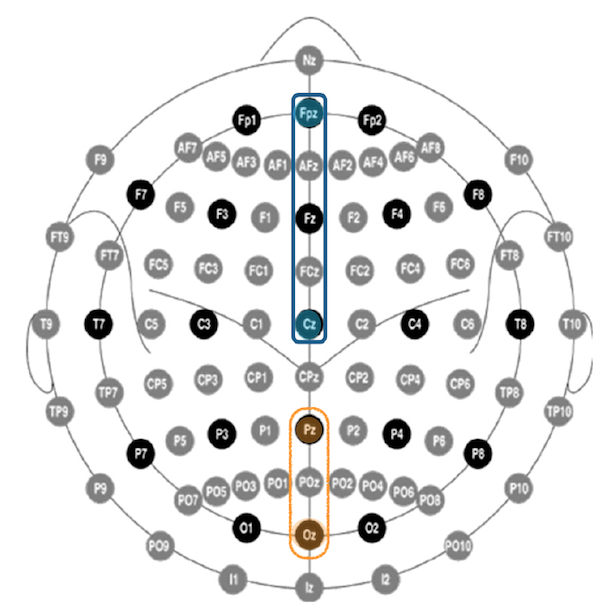

#### Fpz-Cz Channel
____

As its name states, it is an eeg signal with the electrode placed on the forehead and its reference placed on top of the head. Both are centered. They can be seen above in the blue rectangle.

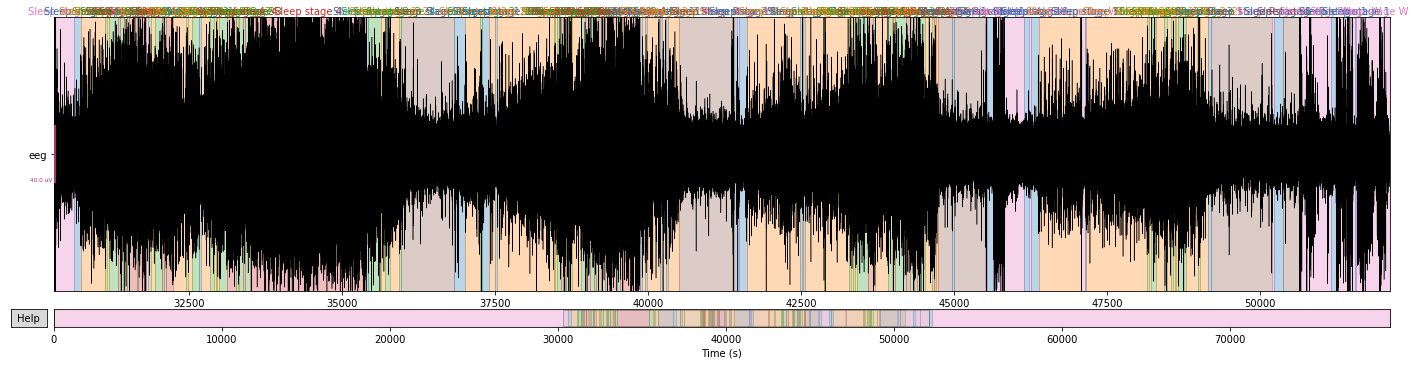

In [10]:
plt.rcParams["figure.figsize"] = (20,5)
raw_data.copy().pick('EEG Fpz-Cz').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

#### Pz-Oz Channel
____

We can see the electrodes located at the back of the head follow the same pattern as with the other channel. The electrode montage for this channel is represented in orange in the figure above. 

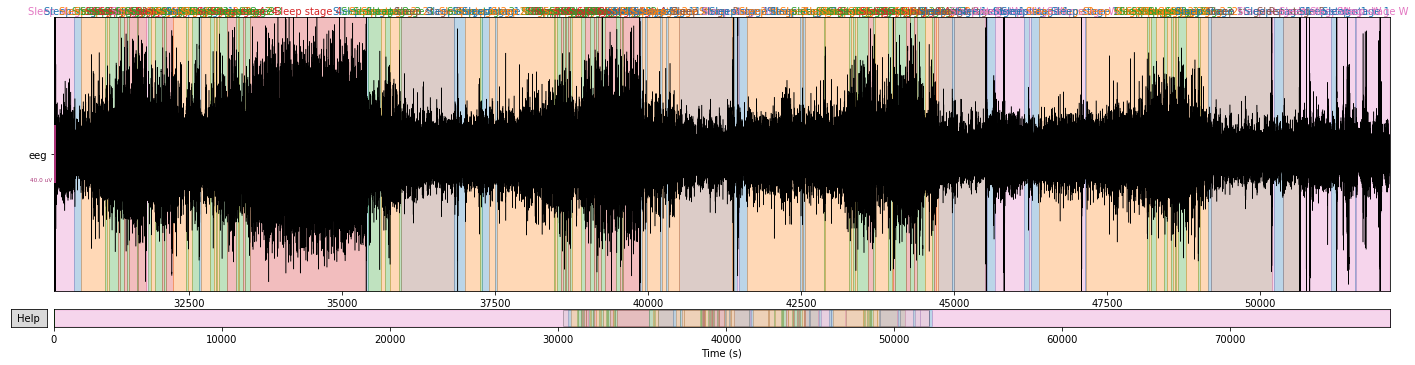

In [11]:
raw_data.copy().pick('EEG Pz-Oz').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

We can see the general amplitude of the **EEG Fpz-Cz** channel is greater than the amplitude of the **EEG Pz-Oz** channel, but the two varies over time and seems to depend on sleep stage.

We can then compare the PSD plot from both channels. 

<ipython-input-12-5dbc023a3bd8>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_data.copy().pick(['EEG Fpz-Cz','EEG Pz-Oz']).plot_psd(tmin=START_WINDOW, tmax=START_WINDOW+DURATION);


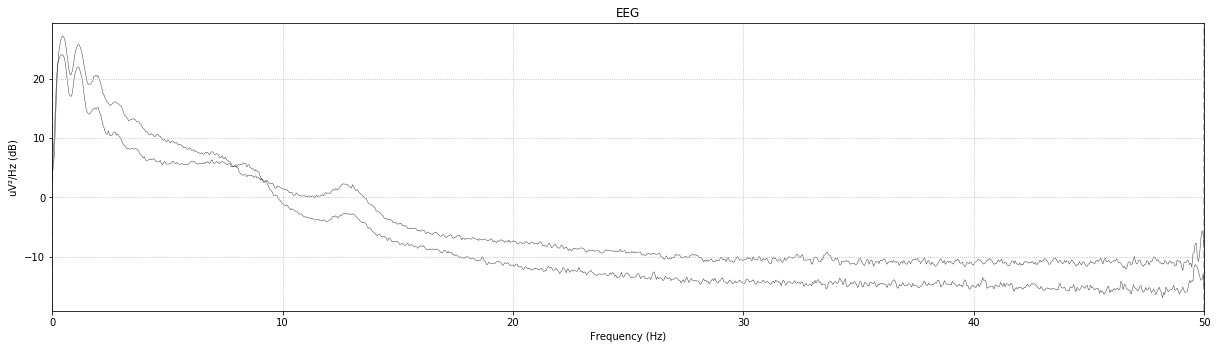

In [12]:
raw_data.copy().pick(['EEG Fpz-Cz','EEG Pz-Oz']).plot_psd(tmin=START_WINDOW, tmax=START_WINDOW+DURATION);

We keep both EEG channels because the goal of the classification is to use them as a way to distinguish sleep stages.

### EOG Channel
____

This channel is a horizontal EOG signal, with electrodes placed on both outer corners of the eyes, as you can see [here](https://www.researchgate.net/figure/Typical-EOG-electrode-placements-for-Horizontal-and-Vertical-channels_fig1_40452196).

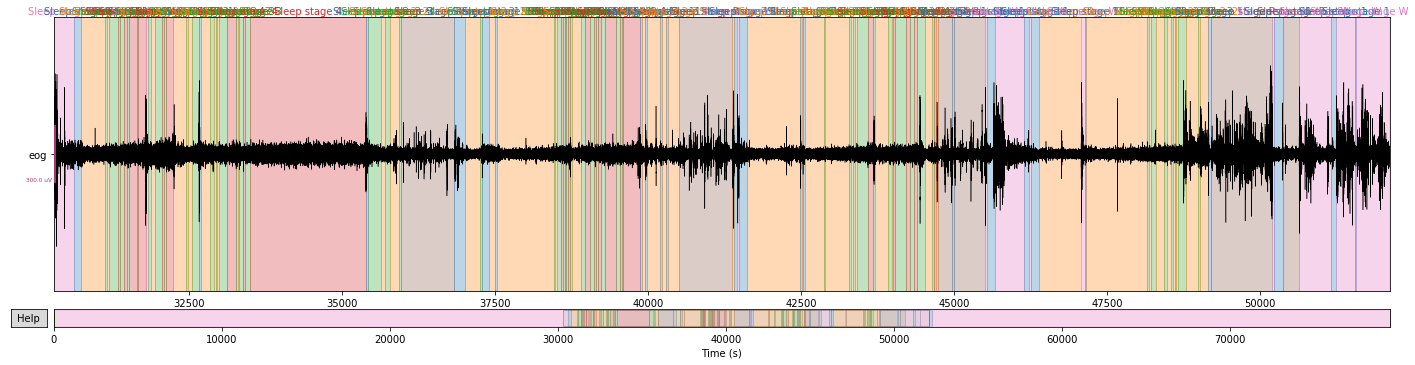

In [13]:
raw_data.copy().pick('EOG horizontal').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

#### Eye movemnent artifact on EEG Channels
____

As it is described in this [tutorial](https://mne.tools/stable/auto_tutorials/preprocessing/plot_10_preprocessing_overview.html#ocular-artifacts-eog), we can detect epochs that contain artefact of eye movement by looking at the EOG signal.

The result of the below operations center all epochs of the EEG channels around the eye movement artefact.

In [14]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw_data)


EOG channel index for this subject is: [2]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1024 samples (10.240 sec)

Now detecting blinks and generating corresponding events
Found 13462 significant peaks
Number of EOG events detected : 13462
13462 matching events found
No baseline correction applied
Not setting metadata
Loading data for 13462 events and 101 original time points ...
1 bad epochs dropped


13461 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


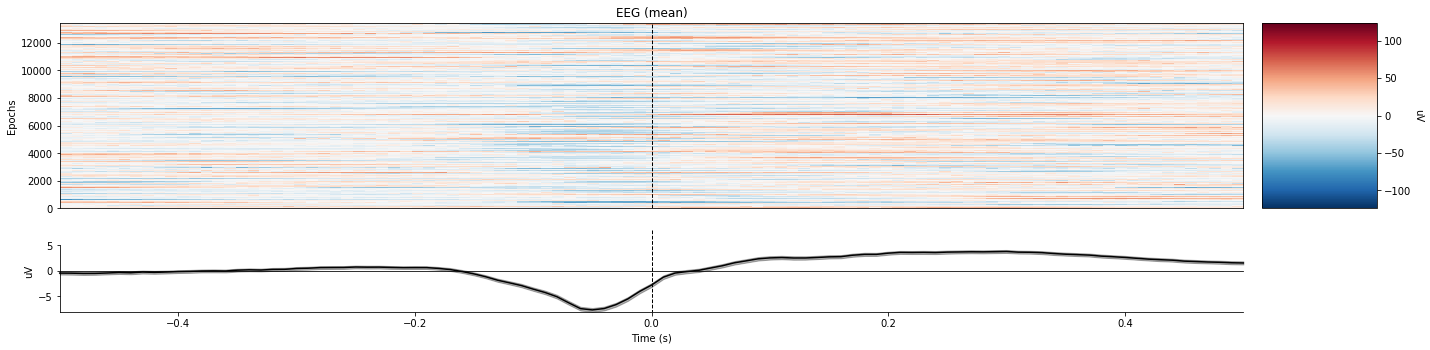

[<Figure size 1440x360 with 3 Axes>]

In [15]:
eog_epochs.plot_image(combine='mean')


Even though the EOG signal is very useful to discriminate REM stage from the S1 stage [[source]](https://en.wikipedia.org/wiki/Polysomnography#Mechanism), we will not include it in our classifier, because we want to keep the montage simple for the end user.

### Chin EMG Channel
____

We finally also have a EMG channel to detect muscle movement near the mouth. We can see the electrodes are sort of placed as below:

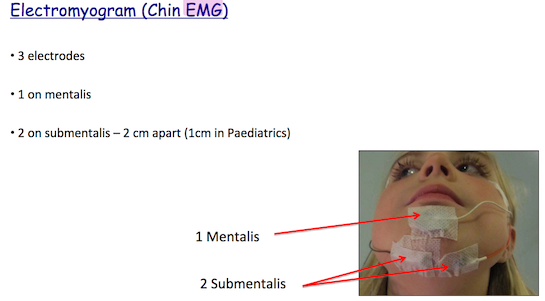

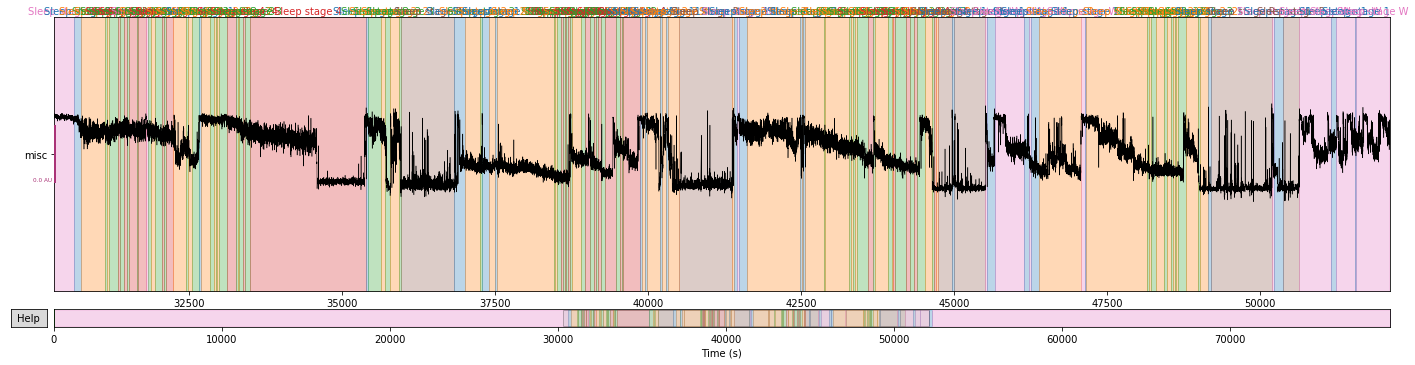

In [16]:
raw_data.copy().pick('EMG submental').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

For the same reason as with the EOG signal, which was to keep the montage simple, we will not use this signal for the classification.

### Event marker
____

It has a sampling rate of 1hz. We know that event markers are usually used to mark events like movements, etc., but here we don't have a proper description of what it means, so we cannot interpret it. We'll therefore ignore it.

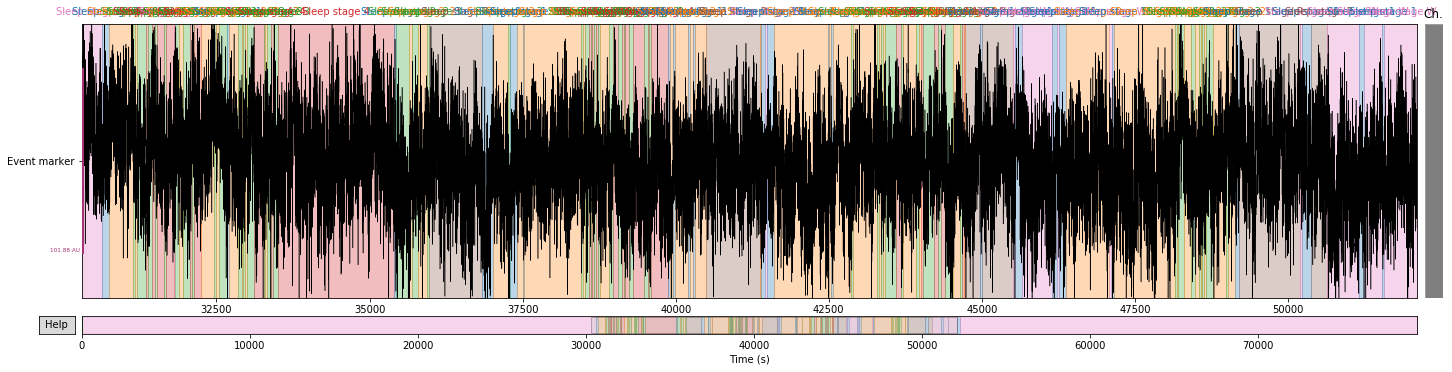

<RawEDF  |  SC4001E0-PSG.edf, n_channels x n_times : 5 x 7950000 (79500.0 sec), ~303.3 MB, data loaded>

In [17]:
raw_data.copy().pick('Event marker').plot(duration=DURATION, start=START_WINDOW);

raw_data.drop_channels(['Event marker'])

# Recordings exploration
___
We currently have **153 night recordings** of 82 subjects. Because we have a limited capacity in terms of memory, we will have to discard some part of the recorded signal. As we've seen in the previous section, files contain a whole day of recording (a little bit less than 24 hours).

We will then discard all recorded signal before the subject turned the lights off and all of the signal after the subject has awaken in the morning. We have to still analyze how many hours of recording we will have left.

We will keep this information in our dataframe, where we define **NightDuration** as the timespan, in seconds, inbetween the time at which the subject closed the lights and the time at which the subject had their last non-wake sleep stage scored.

Even with this data reduction, it will not be enough. Since we do not want to bother with too much data (remember our files are 7.6Gb total), we will only use the 20 first files even if we dropped channels and some of the wake time of the recordings.

In [18]:
start_times = []
lights_off_times = []
lights_off_seconds = []
night_durations = []

for file_index in range(len(subject_files)):

    data = mne.io.read_raw_edf(subject_files[file_index][0], preload=False, verbose=False)
    data.set_annotations(mne.read_annotations(subject_files[file_index][1]), emit_warning=False)
        
    light_off_seconds, light_off_time = get_lights_off_timestamp(data.info, file_index)
    last_non_wake_seconds =  find_last_non_wake_annotation(data.annotations.description, data.annotations.onset)

    night_durations.append(last_non_wake_seconds - light_off_seconds)
    lights_off_times.append(light_off_time)
    lights_off_seconds.append(light_off_seconds)
    start_times.append(datetime.utcfromtimestamp(data.info['meas_date'][0]))
    
    assert (last_non_wake_seconds - light_off_seconds) % 30 == 0, "Must respect epoch size"

df_subject_information['StartRecord'] = start_times
df_subject_information['LightsOff'] = lights_off_times
df_subject_information['LightsOffSecond'] = lights_off_seconds
df_subject_information['NightDuration'] = night_durations

df_subject_information.head(5)

subject  night  age  sex           LightsOff         StartRecord  \
0        0      1   33    1 1989-04-25 00:38:00 1989-04-24 16:13:00   
1        0      2   33    1 1989-04-25 21:57:00 1989-04-25 14:50:00   
2        1      1   33    1 1989-03-29 22:44:00 1989-03-29 16:49:00   
3        1      2   33    1 1989-03-30 22:15:00 1989-03-30 17:00:00   
4        2      1   26    1 1989-04-05 22:50:00 1989-04-05 16:48:00   

   LightsOffSecond  NightDuration  
0          30300.0        21810.0  
1          25620.0        30330.0  
2          21300.0        29250.0  
3          18900.0        31260.0  
4          21720.0        27150.0

In [19]:
print(f"Hours of recording: {df_subject_information['NightDuration'].sum()/3600:.3f}")
print(f"Nb of 30s epochs: {df_subject_information['NightDuration'].sum()/30}")

Hours of recording: 1335.792
Nb of 30s epochs: 160295.0


We then check if any file contains unusual information.

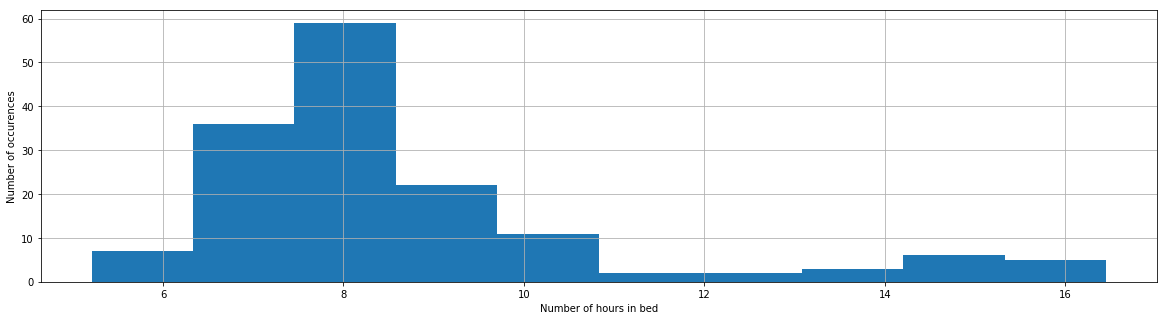

In [20]:
plt.xlabel("Number of hours in bed")
plt.ylabel("Number of occurences")
plt.grid(b=True)
plt.hist([x/3600 for x in df_subject_information['NightDuration']]);

[]

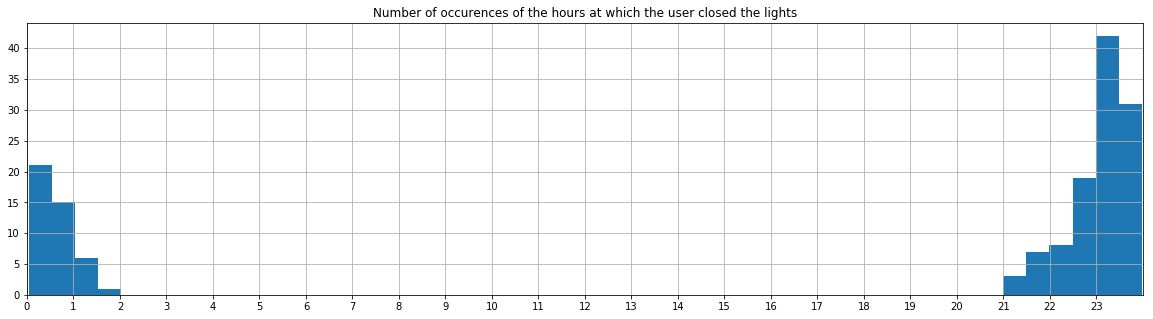

In [21]:
lights_off = df_subject_information['LightsOff']
night_duration = df_subject_information['NightDuration']

plt.figure(figsize=(20, 5))
plt.title("Number of occurences of the hours at which the user closed the lights")
plt.xlim(0, 24)
plt.xticks(range(24))
plt.grid(b=True)
plt.hist(x=[h for h in lights_off.dt.hour + lights_off.dt.minute/60], bins=48)

plt.plot()

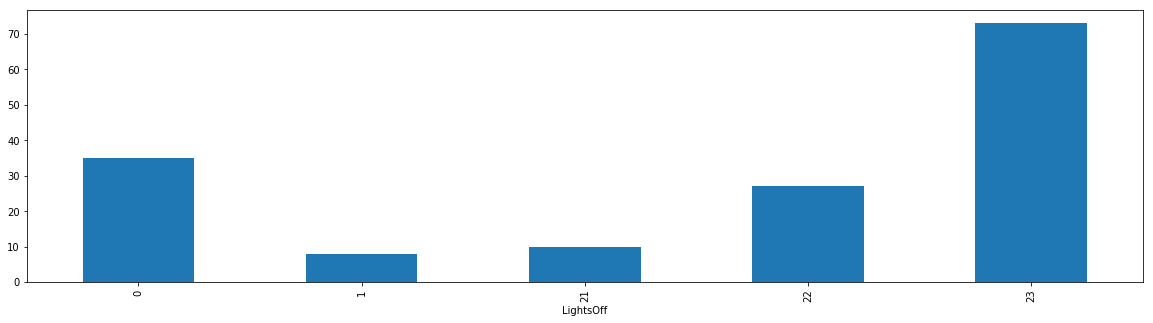

In [22]:
df_subject_information.groupby(df_subject_information["LightsOff"].dt.hour).count()["LightsOff"].plot(kind="bar")

The earliest time at which a subject went to sleep is at about 10 o'clock and the later time at which a subject went to sleep is at about 1:45.

All of the processed information looks good.


# Preprocessing
___

We're using an arbitrary 30 seconds window to create our epochs. We think it should be long enough to get an overview of what is the sleep stage. Also, we're merging the stage 3 and stage 4 into a stage 3/4, because it is the  American Academy of Sleep Medicine official standard since 2007 which is widely used in PSG and hypnograms in general.

# Sleep stage visualization
___

We explore an example of an epoch of each sleep stage in the time domain in order to get an idea of our data.



In [23]:
MAX_TIME = EPOCH_DURATION - 1. / SAMPLING_FREQ  # tmax in included
epochs = get_epochs([3, 8], subject_files, df_subject_information, MAX_TIME, cropping=False)  # We're using these two files in order to have an example of each stages
epochs

Creating epochs for files :  [3, 8]
Concatenating all epochs together...


<Epochs  |   5420 events (all good), 0 - 29.99 sec, baseline off, ~248.1 MB, data loaded,
 'Movement time': 1
 'Sleep stage 1': 258
 'Sleep stage 2': 1280
 'Sleep stage 3/4': 149
 'Sleep stage ?': 2
 'Sleep stage R': 372
 'Sleep stage W': 3358>

In [24]:
EEG_CHANNELS = ['EEG Fpz-Cz','EEG Pz-Oz']

/home/william/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


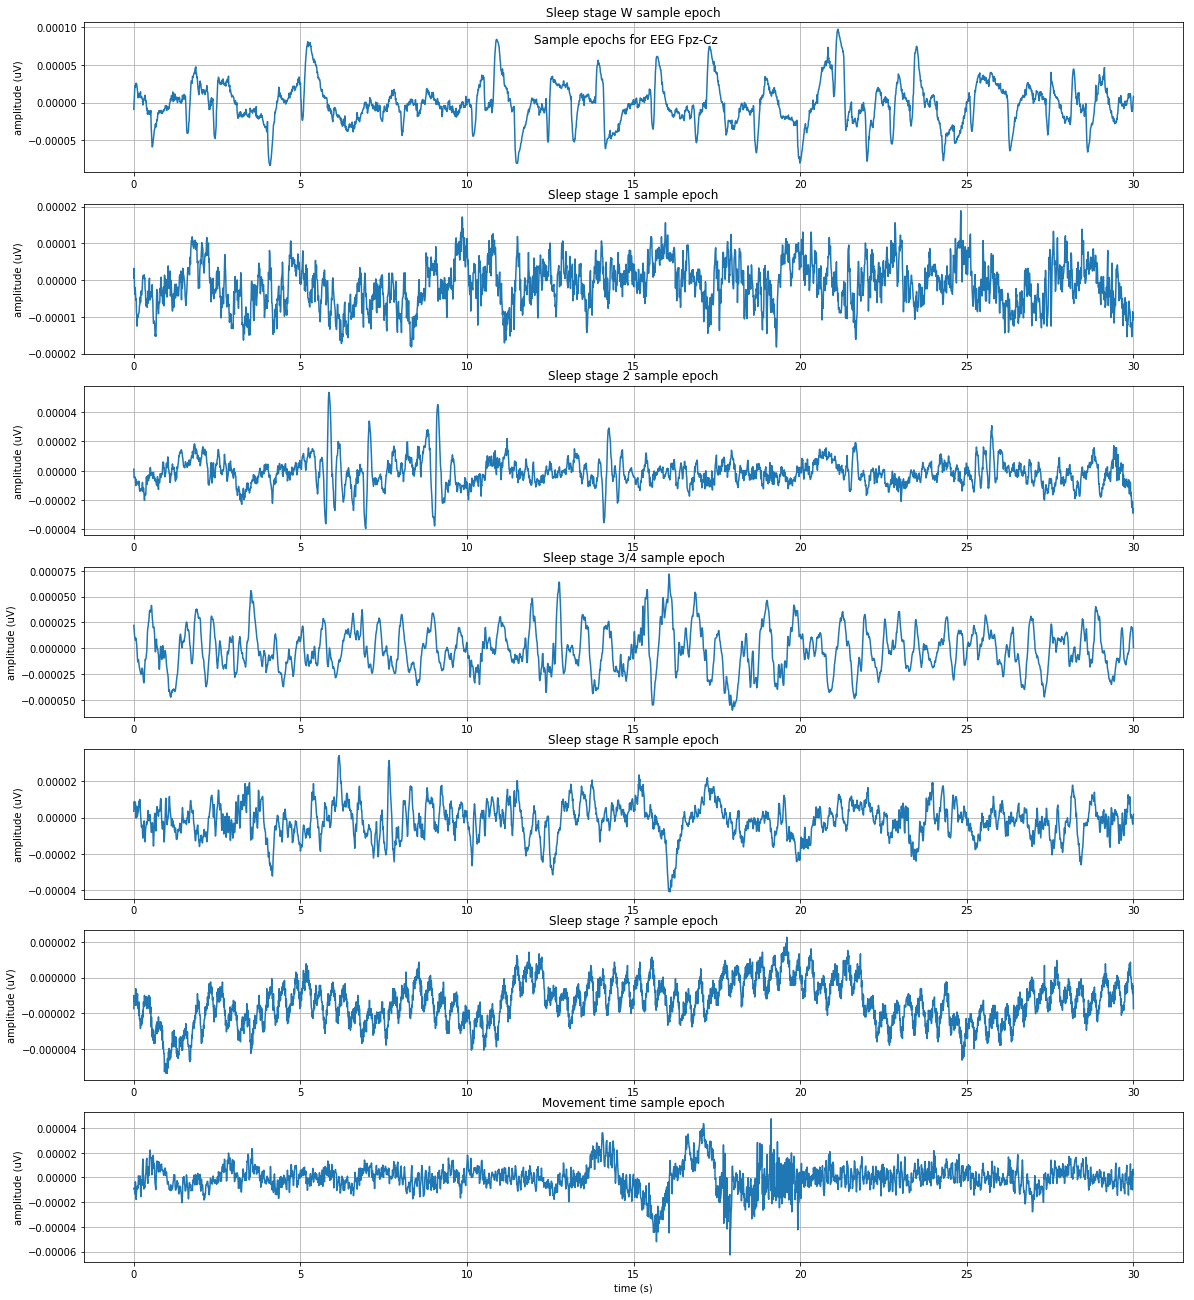

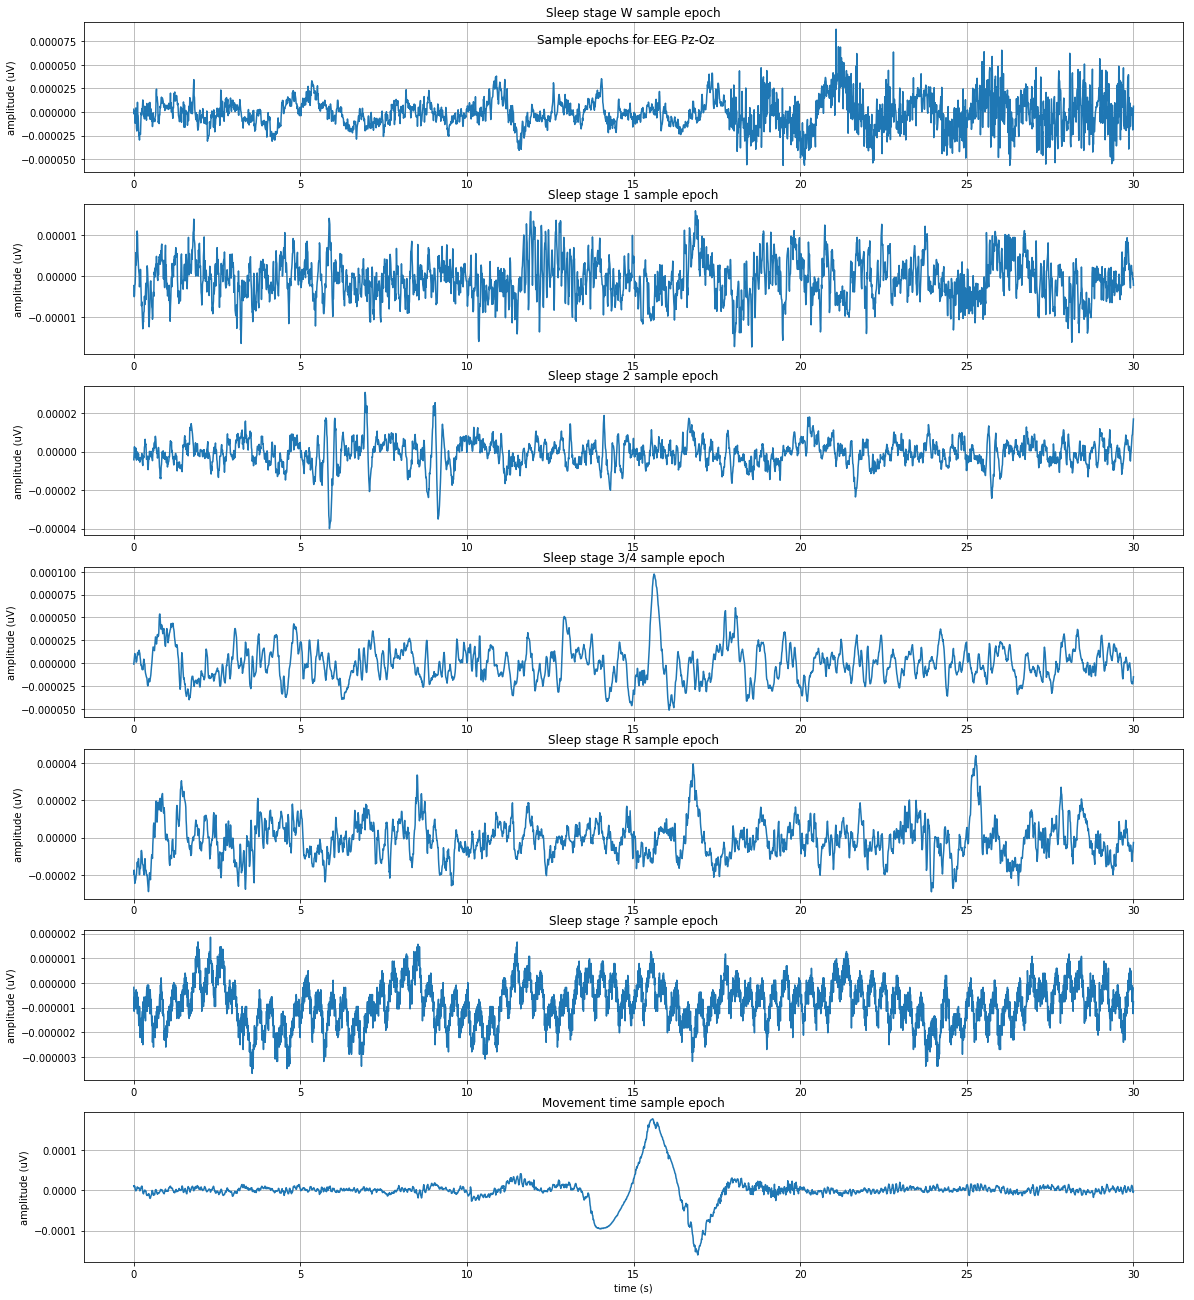

In [25]:
NROWS = len(EVENT_ID)

for j, channel in enumerate(EEG_CHANNELS):
    fig, ax = plt.subplots(nrows=NROWS, figsize=(16,18))
    fig.suptitle(f"Sample epochs for {channel}")
    plt.xlabel("time (s)")

    fig.tight_layout()
    for i in range(NROWS):
        stage = list(EVENT_ID.keys())[i]
        data = epochs[stage][0].get_data().squeeze()
        x = np.linspace(0.0, EPOCH_DURATION, len(data[j]))
        current_ax = ax[i]
        current_ax.grid(b=True)
        current_ax.plot(x, data[j])
        current_ax.set_title(f"{stage} sample epoch")
        current_ax.set_ylabel("amplitude (uV)")
    fig.show()


## Data cleansing
___

We can conclude that the `Sleep stage ?` and `Movement time` tags correspond to the data cleansing that was made by the technician. No need for fancy data cleansing! We will juste exclude them from the epochs.

## Epoching
___
The following code create the epochs and store the files on the local computer. If you want to change the used files i
n this notebook, try to delete data-epo.fif.

If you lack the memory to run this really not optimized notebook, please try to reduce the number of nights you are loading into your epoch object.

In [26]:
FILE_NAME = "data/data-epo.fif" 
NIGHTS = range(0, 20)
if not os.path.isfile(FILE_NAME): 
    epochs = get_epochs(NIGHTS, subject_files, df_subject_information, MAX_TIME)
    epochs.save(FILE_NAME)

Creating epochs for files :  range(0, 20)
Concatenating all epochs together...


<ipython-input-26-458402b8e27b>:5: DeprecationWarning: overwrite defaults to True in 0.18 but will change to False in 0.19, set it explicitly to avoid this warning
  epochs.save(FILE_NAME)


Then, we can retrieve the epochs from the saved file.

In [27]:
epochs = mne.read_epochs("data/data-epo.fif")
epochs 

Reading data/data-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...   29990.00 ms
        0 CTF compensation matrices available
19940 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<EpochsFIF  |   19940 events (all good), 0 - 29.99 sec, baseline off, ~912.8 MB, data loaded,
 'Movement time': 32
 'Sleep stage 1': 1670
 'Sleep stage 2': 8927
 'Sleep stage 3/4': 3074
 'Sleep stage R': 3693
 'Sleep stage W': 2544>

**Clean the data:**

In [28]:
events = list(epochs.event_id.keys())
if 'Movement time' in events:
    events.remove('Movement time')
if 'Sleep stage ?' in events:
    events.remove('Sleep stage ?')

epochs = epochs[events]

Now we have 1.71Gb of data and our stages are pretty much balanced.


## Analyzing PSD of epochs grouped by sleep stage score
____

We want to check if [power band amplitudes](https://raphaelvallat.com/bandpower.html) change depending on the epoch's sleep stage class. We will then take all epochs with the same classification and then display their respective PSD.

The power spectrum density is meaningful only for stationary signals. Since our EEG data is not a stationary signal, we'll use the Welch's method to estimate the PSG. The Welch's method is a simple method to estimate PSG by calculating an EEG for smaller windows on our epoch. Then, these PSDs are averaged in order to get an idea of the PSG of the entire epoch. The tradeoff of doing so is a decrease in frequency resolution, but more precision on the PSD. We will use the [0.5, 30] Hz frequency band because it does not contain the DC and the electromagnetic interferences of 50/60Hz that may lead to misconceptions about the EEG activity.

In [29]:
epochs_df = epochs.to_data_frame(long_format=True, picks="eeg", copy=False)  # We don't want to copy all this data in memory!!!

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


In [30]:
epochs_df.head()

condition epoch  time     channel  observation ch_type
0  Sleep stage W     0   0.0  EEG Fpz-Cz     3.704029     eeg
1  Sleep stage W     0   0.0   EEG Pz-Oz   -19.358242     eeg
2  Sleep stage W     0  10.0  EEG Fpz-Cz    11.674725     eeg
3  Sleep stage W     0  10.0   EEG Pz-Oz    -2.371429     eeg
4  Sleep stage W     0  20.0  EEG Fpz-Cz     5.110623     eeg

In [31]:
epoch_events = epochs_df[['epoch', 'condition']].drop_duplicates(keep="first").set_index('epoch')['condition'].to_numpy()

In [32]:
# psds will be of shape (n_epochs, n_channels, n_freqs) i.e. X epochs x 2 channel x 75 freq

psds, freqs = mne.time_frequency.psd_welch(epochs, picks=EEG_CHANNELS, fmin=0.5, fmax=30.)

Effective window size : 2.560 (s)


In [33]:
len(freqs)

75

In [34]:

'''
ce qu'on voudrait serait un dataframe avec les colonnes suivantes
(pareil à epochs_df, sauf dans domain frequency avec psd):

- sleep-stage: event_id
- epoch: no de l'epoch
- frequency: fréquence issu de `freqs` (similaire à `time`de epochs_df)
- channel: EEG Fpz-Cz ou EEG Pz-Oz
- psd: valeur issue de `psds`

'''
psds_df_dict = { "stage": [],  "epoch": [], "frequency": [], "channel": [], "psd": [] }
NO_FREQS = len(freqs)

for no_epoch in range(len(psds)):
    current_sleep_stage = epoch_events[no_epoch]

    for no_channel in range(len(EEG_CHANNELS)):
        current_channel = EEG_CHANNELS[no_channel]
        
        psds_df_dict["stage"].extend([current_sleep_stage] * NO_FREQS)
        psds_df_dict["epoch"].extend([no_epoch] * NO_FREQS)
        psds_df_dict["channel"].extend([current_channel] * NO_FREQS)

        psds_df_dict["frequency"].extend(freqs)
        psds_df_dict["psd"].extend(psds[no_epoch][no_channel])


In [35]:
epoch_psds_df = pd.DataFrame(psds_df_dict)
epoch_psds_df

stage  epoch  frequency     channel           psd
0        Sleep stage W      0   0.781250  EEG Fpz-Cz  1.262522e-09
1        Sleep stage W      0   1.171875  EEG Fpz-Cz  4.754175e-10
2        Sleep stage W      0   1.562500  EEG Fpz-Cz  1.753326e-10
3        Sleep stage W      0   1.953125  EEG Fpz-Cz  1.273632e-10
4        Sleep stage W      0   2.343750  EEG Fpz-Cz  7.845222e-11
...                ...    ...        ...         ...           ...
2986195  Sleep stage W  19907  28.125000   EEG Pz-Oz  9.949883e-12
2986196  Sleep stage W  19907  28.515625   EEG Pz-Oz  1.002685e-11
2986197  Sleep stage W  19907  28.906250   EEG Pz-Oz  6.354336e-12
2986198  Sleep stage W  19907  29.296875   EEG Pz-Oz  7.719137e-12
2986199  Sleep stage W  19907  29.687500   EEG Pz-Oz  1.041193e-11

[2986200 rows x 5 columns]

### Average bands power for δ, θ, α, β and γ
___

To get an essence of the full distribution, we will calculate the relative power for each frequency band (delta, theta, alpha, beta, gamma) as often used in EEG experiments. Then, we'll plot a violin for each relative band power.

Average band power can be obtained by integrating our psd for each frequency band. To numerically calculate our integral, we can calculate the sum of our psd data points for each frequency band. But first, we need to define our frequency bands ranges:

In [36]:
FREQ_BANDS = {
    "delta": [0.5, 4.5],
    "theta": [4.5, 8.5],
    "alpha": [8.5, 11.5],
    "sigma": [11.5, 15.5],
    "beta": [15.5, 30]
}

Then, we need to find calculate the power of each of these 5 frequency bands for every epochs we have.

In [37]:
def add_labels_on_plot(ax, stages):
    ax.set_xticks(np.arange(1, len(stages) + 1))
    ax.set_xticklabels(stages)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Sleep stage')
    ax.set_ylabel('Power uV^2/Hz')

def plot_average_band_power_per_chan(df, ax, channel, stages, band, fmin, fmax, relative):
    X = []
    for stage in stages:
        x = None
        stages_psds = df.query(f"channel == '{channel}' & stage == '{stage}'")
        epochs_total_power = stages_psds.groupby('epoch').psd.agg(['sum'])
        band_psds = stages_psds[(fmin < stages_psds.frequency) & (fmax >= stages_psds.frequency)]
        x = band_psds.groupby('epoch').psd.agg(['sum'])
        if relative:
            x = x.div(epochs_total_power)
        X.append(x.to_numpy().squeeze())
    ax.set_title(f"Average frequency power for the {band} band [{fmin}, {fmax}]")
    ax.grid(b=True)
    ax.violinplot(X, showmeans=True)
    add_labels_on_plot(ax, stages)
    
# Epochs average_relative_band_power = epoch_mean_band_power / epoch_mean_total_power

def plot_average_band_power(df, channel, relative=False):
    fig, ax = plt.subplots(nrows=len(FREQ_BANDS),figsize=(16, 16))
    stages = df.stage.unique()
    for i, (band, (fmin, fmax)) in enumerate(FREQ_BANDS.items()):
        plot_average_band_power_per_chan(df, ax[i], channel, stages, band, fmin, fmax, relative)

    plt.tight_layout()
    title_relative = "relative" if relative else "absolute"
    fig.suptitle(f"Average {title_relative} frequency power for each power band for the {channel} channel", fontsize=18, fontweight='bold', y=1.05)

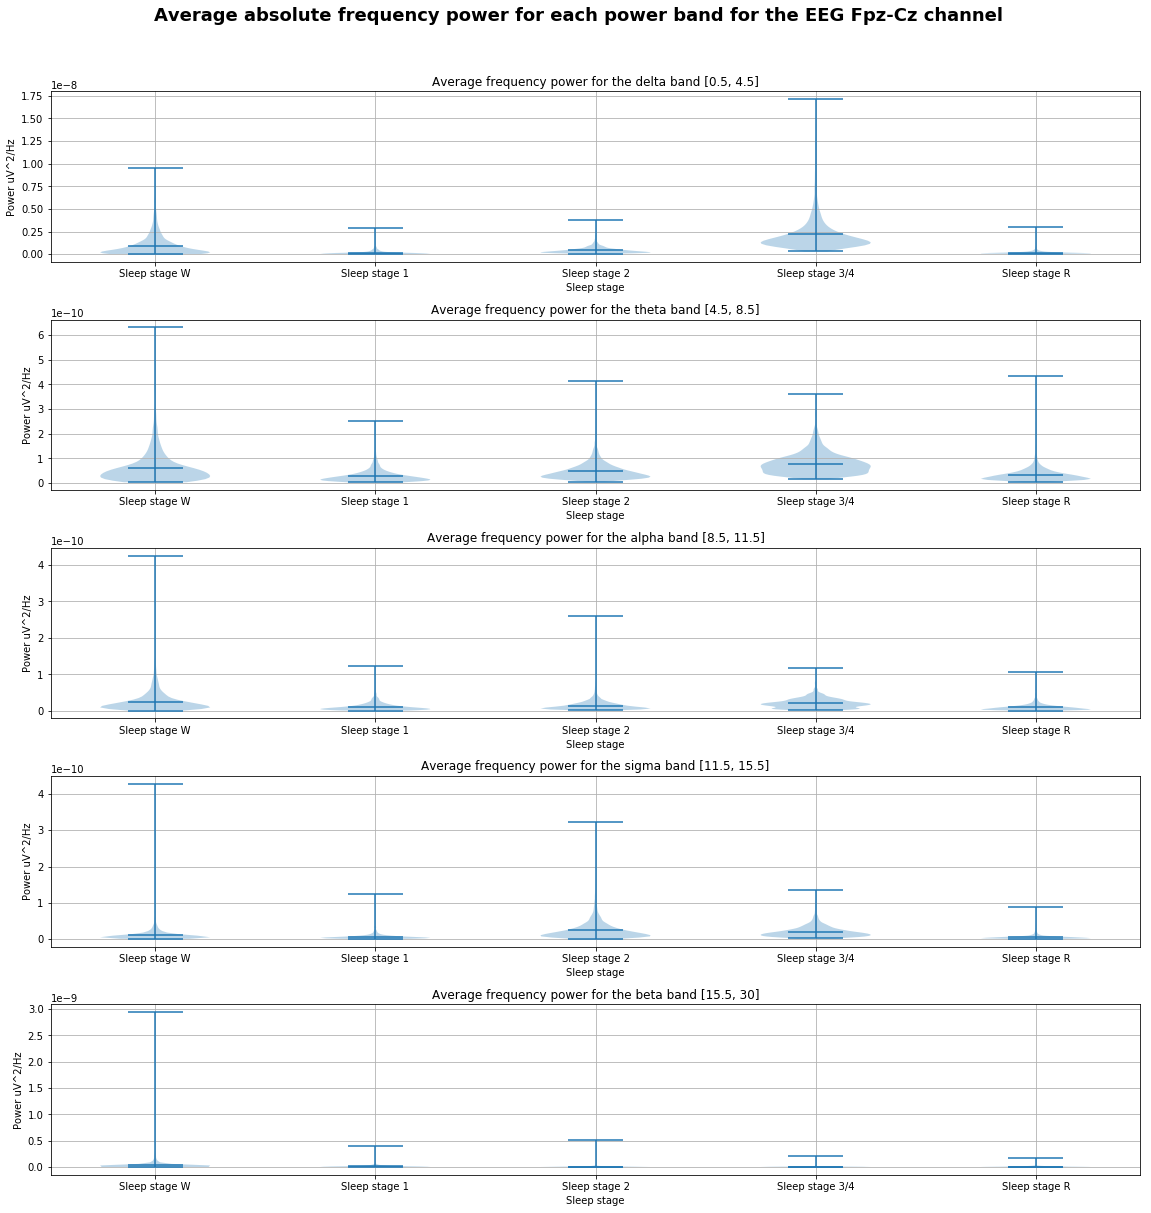

In [38]:
plot_average_band_power(epoch_psds_df, 'EEG Fpz-Cz')

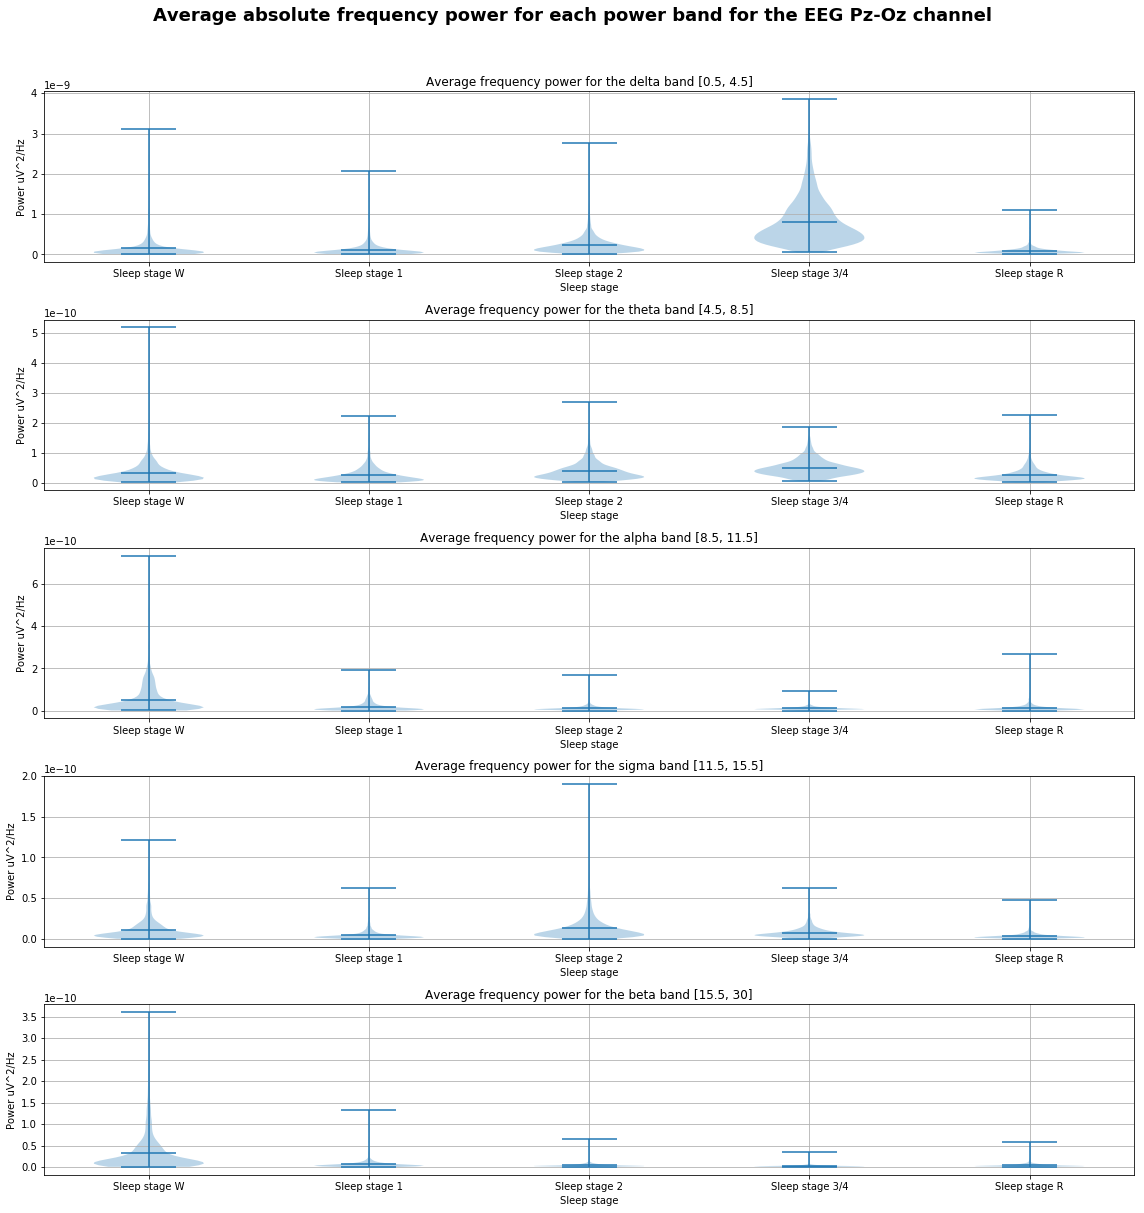

In [39]:
plot_average_band_power(epoch_psds_df, 'EEG Pz-Oz')

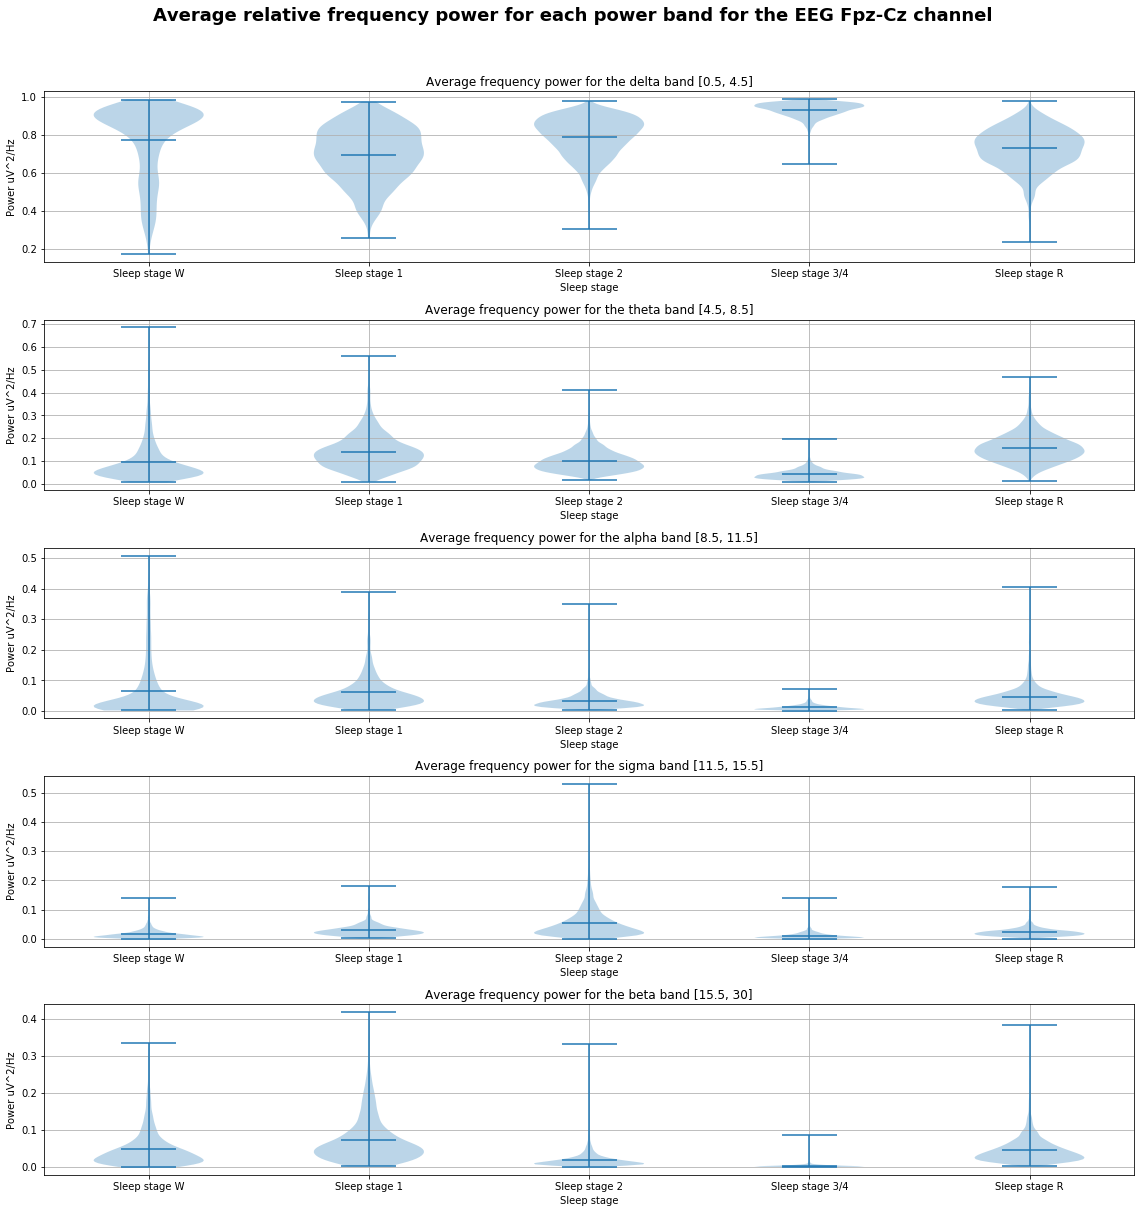

In [40]:
plot_average_band_power(epoch_psds_df, 'EEG Fpz-Cz', relative=True)

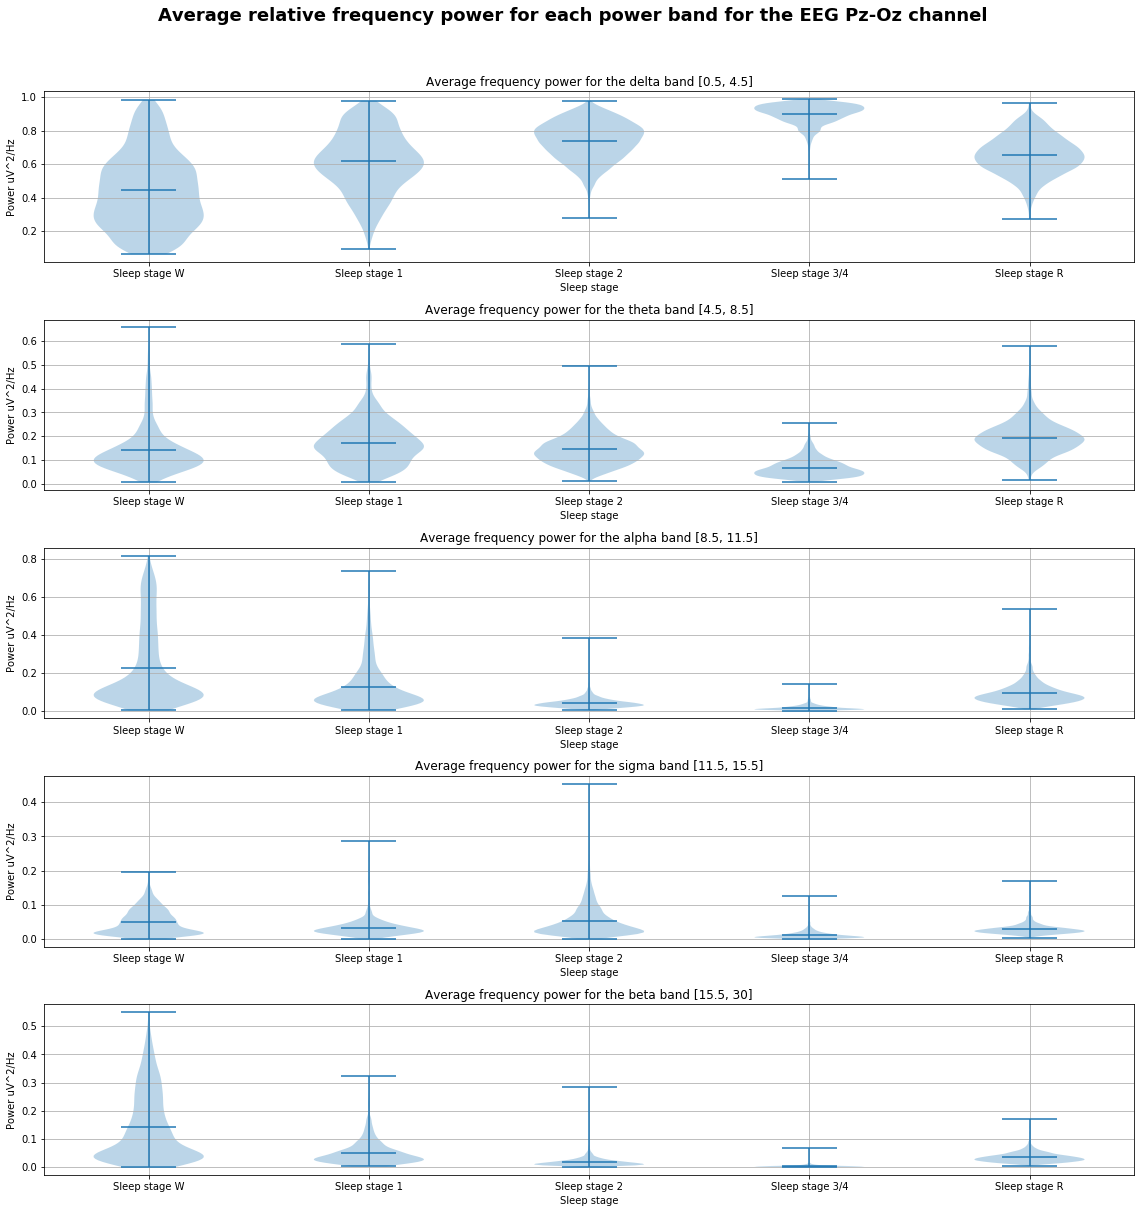

In [41]:
plot_average_band_power(epoch_psds_df, 'EEG Pz-Oz', relative=True)

### What we see
___

**Absolute band power:** This is a data reduction of the information just shown but now we have an idea of the distribution of each power bands. What we realize here is that even though `Sleep stage 1` and `Sleep stage R` means where really close from each other in the 95% most common psds vizualisation, now we see that their distribution is practically the same for all frequency bands. We will surely need a better way to discriminate these stages from each other.

**Relative band power:** This features compare the amount of power contained in a frequency band with all the other bands. It seems to be an interesting feature to compare all the stages between them. Pretty much all the frequency bands have something to say about the sleep stage.

### Spectral Edge Frequency (SEF)
___

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4204008/

As advised by the paper, we calculate SEFd for the frequencies between 8 and 16 Hz. SEFx the frequency f that contains x% of the power of the 8 to 16Hz fourier coefficients.

$$\int_{8}^{f} |fourier[i]|^2 \partial i = x \int_{8}^{16} |fourier[i]|^2 \partial i$$
$$f = ?$$


```
The reason for high SEFd values is a result of lower SEF50 and higher SEF95 values during REM stages. The two trends in SEF can be explained by the observations in Fig. ​Fig.11 which shows how the power within the 8–16 Hz band changes during both REM and non-REM stages (including Wake). The power is similar in both REM and non-REM around 8 Hz. Following this, the power in REM is lower than non-REM from 9–15 Hz with the difference being highest around the 12 Hz mark. Uchida et al.40 reported the absence of 12–16 Hz activity during REM stages which is causing the power to be lower than non-REM. Therefore the median frequency (SEF50) in 8–16 Hz range is expected to be lower during REM stages. The trend of higher SEF95 values during REM suggests an increase in the higher frequency components of the 8–16 Hz band. In Fig. ​Fig.1,1, apart from ​from1e,1e, all cases demonstrate an increase in the power spectrum of REM around the 15 Hz mark. Further, the activity in the neighbouring beta frequency band is also highest during REM sleep.40 This causes the SEF95 values to be higher during REM within the 8–16 Hz range. SEFd essentially represents both these changes in SEF50 and SEF95, which is observed to be greatest when the frequency band is limited between 8 Hz and 16 Hz.
```

```
The difference between SEF95 and SEF50 is used as a novel feature for REM stage detection in this work. This difference is hereon referred to as SEFd. For an epoch e, it is determined by first calculating the SEFd values of fifteen 2 s subepochs in the 30 s EEG epoch (i.e., the difference between SEF95 and SEF50 of the subepochs). The mean of these differences is taken to be the SEFd of the epoch being processed as shown in (3) where se is the subepoch and n is its index. A 9-point moving average filter is then applied to the final SEFd value.
```

We believe they used 2s subwindows in order to increase the signal to noise ratio. Since we're calculating our psds using Welch's method, we consider this is not an issue and that we can directly use what we previously calculated.

Now, we want our violins for an SEFd feature for each epochs. SEFd is defined as the difference between two SEFx. We won't apply the 9 points moving average because we can't do it with the actual epoch dataframe we have. We'll process epochs one night at a time in our training in order to palliate to this issue.


In [42]:
def plot_freq_domain_distribution(epoch_psds_df, measure_type, unit_label=""):
    fig, ax = plt.subplots(nrows=2,figsize=(16,10))
    stages = epoch_psds_df.stage.unique().astype(str)
    print(f"The ordered violins are for: {stages}")

    for i, channel in enumerate(epoch_psds_df['channel'].unique()):
        stats_epoch_df = epoch_psds_df \
            .query(f"channel == '{channel}'") \
            .sort_values(by=['epoch','frequency']) \
            .groupby('epoch') \
            .agg({'stage': 'first', 'psd': measure_type})

        ax[i].violinplot([stats_epoch_df.query(f"stage == '{stage}'").psd.values for stage in stages],showmeans=True)
        ax[i].set_title(f"Distribution of the {measure_type} signal for {channel}")
        ax[i].set_ylabel(unit_label)
        ax[i].set_xticks(np.arange(1, len(stages) + 1))
        ax[i].set_xticklabels(stages)

    plt.show()

In [43]:
frequencies = epoch_psds_df.frequency.unique()
DELTA_FREQ = frequencies[1] - frequencies[0]
HZ_8_IDX = int(8//DELTA_FREQ) + 1
HZ_16_IDX = int(16//DELTA_FREQ) + 1

In [44]:
def SEF(x, psd):
    """
    x: percentage of the power
    psd: array of the power spectrum density
    return: freq that contains this percentage of the power
    """
    psd = psd.to_numpy()
    total_power = np.sum(psd[HZ_8_IDX: HZ_16_IDX])
    partial_power = 0
    f = 0
    for i, amp in enumerate(psd[HZ_8_IDX: HZ_16_IDX]):
        partial_power += amp
        if partial_power >= (x/100) * total_power:
            f = i
            break
    
    return (f + HZ_8_IDX) * DELTA_FREQ

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


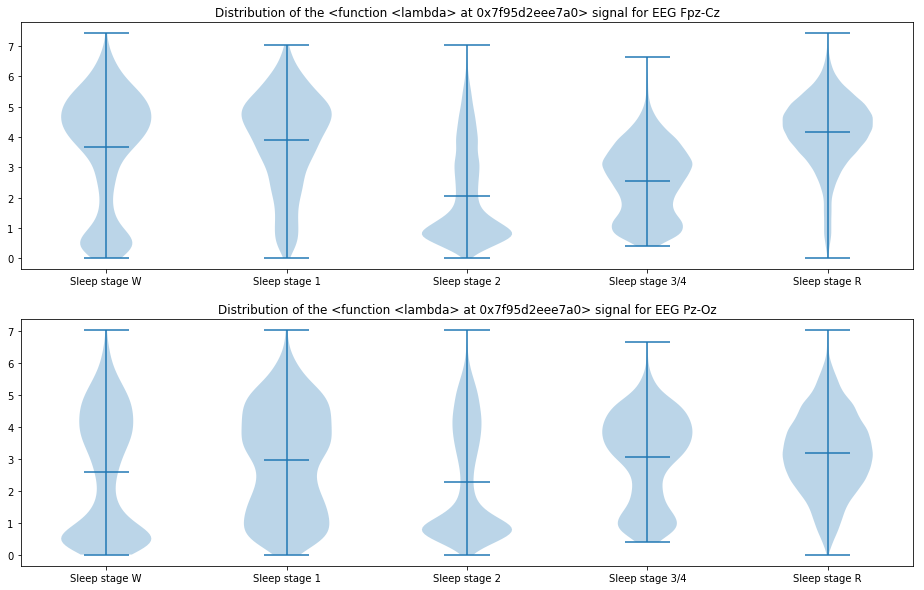

CPU times: user 13.8 s, sys: 379 ms, total: 14.2 s
Wall time: 18.5 s


In [45]:
%%time
plot_freq_domain_distribution(epoch_psds_df, measure_type=lambda psd: SEF(95, psd) - SEF(50, psd))

### What we see
___

SEFd could do a good job at identifying N1 and REM. However, **we did not apply a mean filter and maybe that is why it is not working**. However, it would be kind of time consuming to filter the signal in this notebook (we did not expected to do so at this point).

### Show mean psd
___

Let's show the mean PSD for each class with the standard deviation.

In [46]:
scaling = 1e12 # see here for default eeg scaling using for plotting (i.e. plot_psd): https://github.com/mne-tools/mne-python/blob/c437ed0bbcef3b6bf3a8beab2221ab5bff47722f/mne/defaults.py#L20 
epoch_psds_df['psd'] *= scaling
# Convert to decibels
epoch_psds_df['psd'] = np.log10(np.maximum(epoch_psds_df['psd'], np.finfo(float).tiny)) * 10

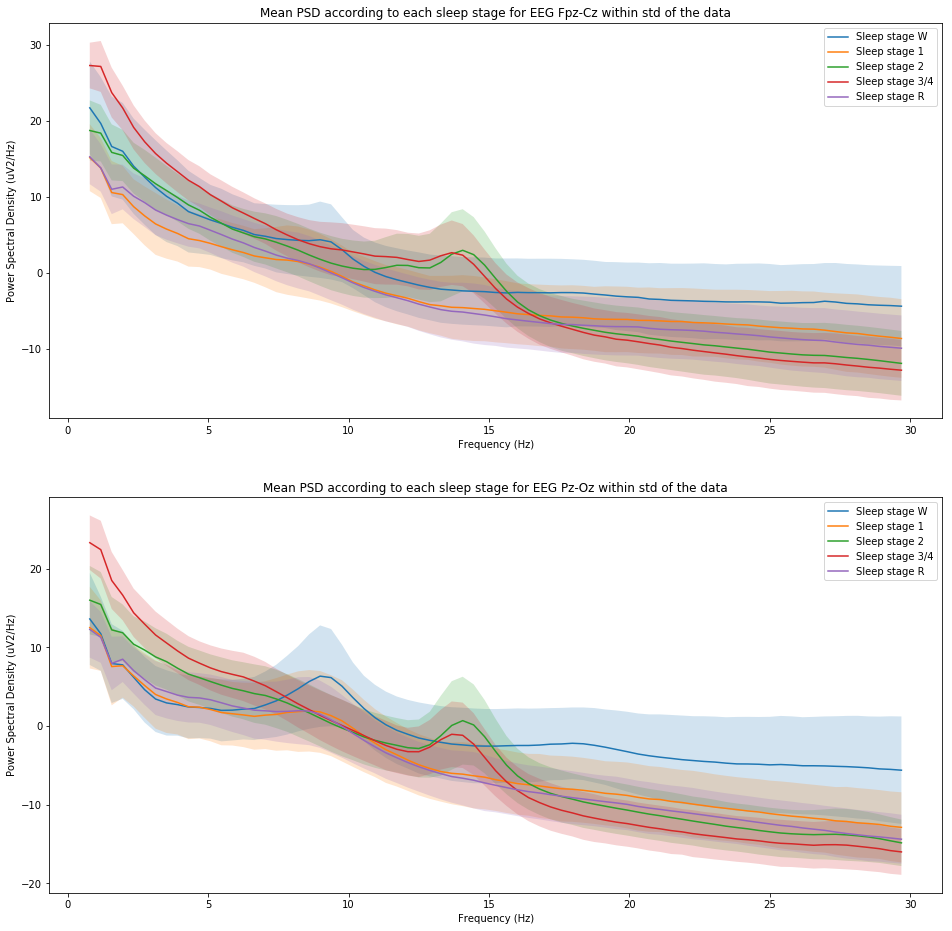

In [47]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 16))

def plot_mean(x, y, name, ax, percentile=None):
    """ This function plot a channel line according"""
    calculation_df =  y.agg(['mean', 'std'])
    ax.plot(calculation_df.index, calculation_df['mean'], label=name)
    if percentile is 'std':
        ax.fill_between(x=x, y1=calculation_df['mean']+calculation_df['std'], y2=calculation_df['mean']-calculation_df['std'], alpha=0.2)
    elif percentile is 'range':
        lower_bound = y.quantile(0)
        upper_bound = y.quantile(1)
        ax.fill_between(x=x, y1=lower_bound, y2=upper_bound, alpha=0.2)
    elif percentile:
        if not 0 <= percentile <= 1:
            raise ValueError('percentile must be std or in the [0, 1] range')
        alpha = 1 - percentile
        lower_bound = y.quantile(alpha/2)
        upper_bound = y.quantile(1-(alpha/2))
        ax.fill_between(x=x, y1=lower_bound, y2=upper_bound, alpha=0.2)

def plot_stages_mean_psd(df, channel, ax, percentile=None):
    stages_psds = {stage: epoch_psds_df.query(f"channel == '{channel}' & stage == '{stage}'").groupby('frequency').psd for stage in epoch_psds_df.stage.unique()}
    freqs = epoch_psds_df.frequency.unique()
    for stage, psds in stages_psds.items():
        plot_mean(freqs, psds, stage, ax, percentile=percentile)
    ax.legend()
    title = f"Mean PSD according to each sleep stage for {channel}"
    title = title + f" within {percentile} of the data" if percentile else title
    ax.set_title(title)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density (uV2/Hz)')

plot_stages_mean_psd(epoch_psds_df, 'EEG Fpz-Cz', ax[0], percentile='std')
plot_stages_mean_psd(epoch_psds_df, 'EEG Pz-Oz', ax[1], percentile='std')

### What we see
___

When looking at the standard deviation of the psds datapoints of the Pz-Oz channel, we can see that some are not overlapping a lot which is great news for sleep stage classification. For example, at the beggining of the spectrum, sleep stage 3/4 can be clearly discriminated from the other stages. At the end of the spectrum (highest freqs), we can see that wake can be discriminated from sleep.
### With 95% most common values
___

We can use the range of the 95% most common values in order to have an idea of the range of the psd observations without the most obvious outliers (5% farthest values from the mean).

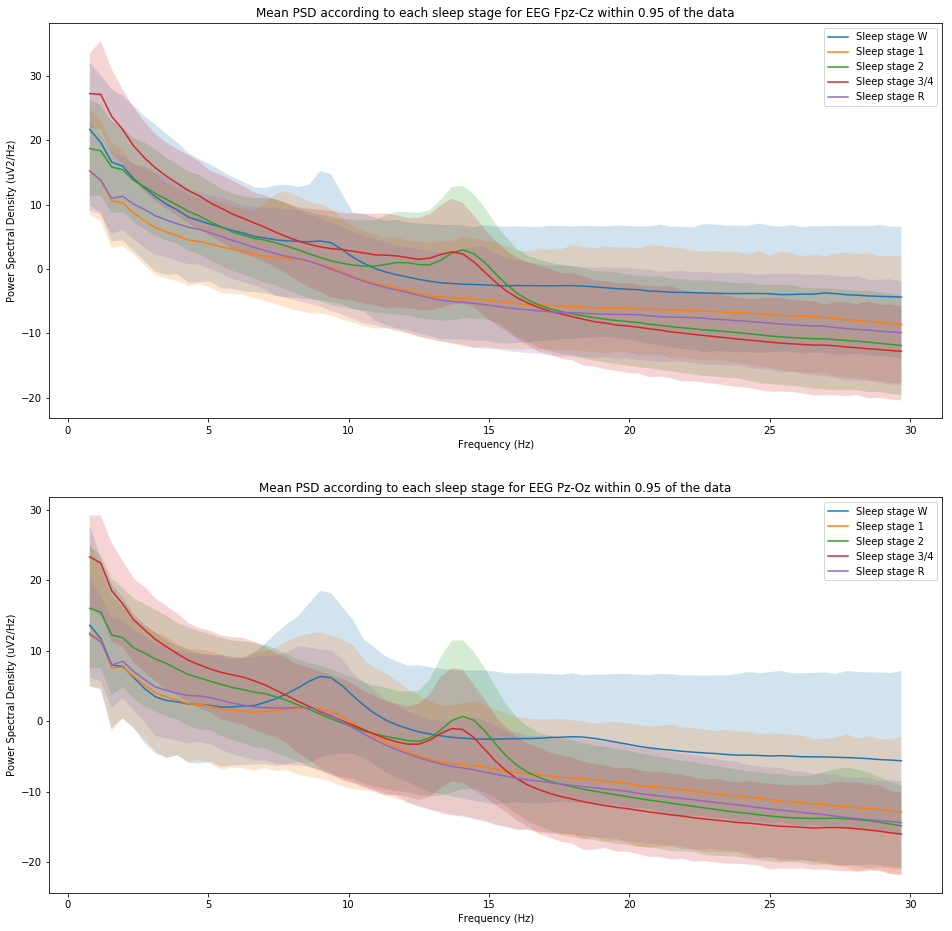

In [48]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 16))

plot_stages_mean_psd(epoch_psds_df, 'EEG Fpz-Cz', ax[0], percentile=0.95)
plot_stages_mean_psd(epoch_psds_df, 'EEG Pz-Oz', ax[1], percentile=0.95)

### What we see
___
In this plot, we can see that deep sleep is linked to more power into slow waves and that wake stages are linked to more power at high frequencies.

Also, we suspect that the little hill between 11 and 16 Hz for sleep stage 2 is caused by spindles. However, we think we need a better detection method for the spindles, since it will not be easy to discriminate from the other stages. Also, we can see that the range of the values for the psd of each stage is overlapping with each other wich seems to makes it harder to discriminate a stage with another. Distributions of frequency bands gave us more useful informations.

## Analyzing time domain features on the epoch
___

Time domain features are easy to extract and can hold some information about the current sleep stage the subject is in. Moreover, manual sleep stage scoring is mostly realized only on the time domain EEG epochs, which indicates it is possible to select valuable time domain features.

### a. Standard statistics
___

The first features we will explore are the statiscical moments of each epoch. **Moments are a set of statistical parameters to measure a distribution**. In our case, we are looking at the distribution of the amplitudes (microVolt) accross all 30s epochs grouped by EEG channel and by sleep stage.

According to Koley [[1]](https://www.sciencedirect.com/science/article/pii/S0010482512001588?via%3Dihub#bib36), the statistical parameters can be used as features in order to classify sleep stages:

 > Among the various statistical properties of the EEG time series, the first- to fourth-order moments have already been used in preceding studies [28], [29], [32]. **The variance of EEG (M2) was found suitable for discriminating REM sleep from S2 and SWS [29].** These first- to fourth-order statistical parameters i.e., mean (M1), variance (M2), skewness (M3) and kurtosis (M4) were computed for the EEG epoch X(n) to quantify the central tendency, degree of dispersion, asymmetry and peakedness, respectively. These measurements were calculated using the formulas given in [36].
 
For each epoch and for each EEG channel, we want to look if we can discriminate the sleep stages with the following parameters: mean, variance, skewness and kurtosis.

***Note on how to read the following figures:***
The mean of the parameter is represented by the middle horizontal trait. The shape of the distribution of the parameter is represented by the blue area. Finally, the vertical bar represents the 100% confidence interval (range) of the calculated parameter. There is a calculation of the parameter for each epoch.

In [49]:
def plot_time_domain_distribution(epochs_df, measure_type, unit_label=""):
    fig, ax = plt.subplots(nrows=2,figsize=(16,10))
    stages = epochs_df.condition.unique().astype(str)
    print(f"The ordered violins are for: {stages}")

    for i, channel in enumerate(epochs_df['channel'].unique()):
        stats_epoch_df = epochs_df \
            .query(f"channel == '{channel}'") \
            .sort_values(by=['epoch','time']) \
            .groupby('epoch') \
            .agg({'condition': 'first', 'observation': measure_type})

        ax[i].grid(b=True)
        ax[i].violinplot([stats_epoch_df.query(f"condition == '{stage}'").observation.values for stage in stages], showmeans=True)
        ax[i].set_title(f"Distribution of the {measure_type} signal for {channel}")
        ax[i].set_ylabel(unit_label)
        ax[i].set_xticks(np.arange(1, len(stages) + 1))
        ax[i].set_xticklabels(stages)

    plt.show()

#### I - Distribution of the mean of the signal
___

We plot the distribution of the mean values of all epochs. We can see the mean value of the mean time domain signal is generally the same within all epochs of the same observed channel (i.e. 0.4 uV for the Fpz-Cz channel and 0.25 uV for the Pz-Oz channel).

We can also see the distribution of the mean are generally the same within the same channel, so much that we think the mean of the signal would not be a signigicant feature.

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


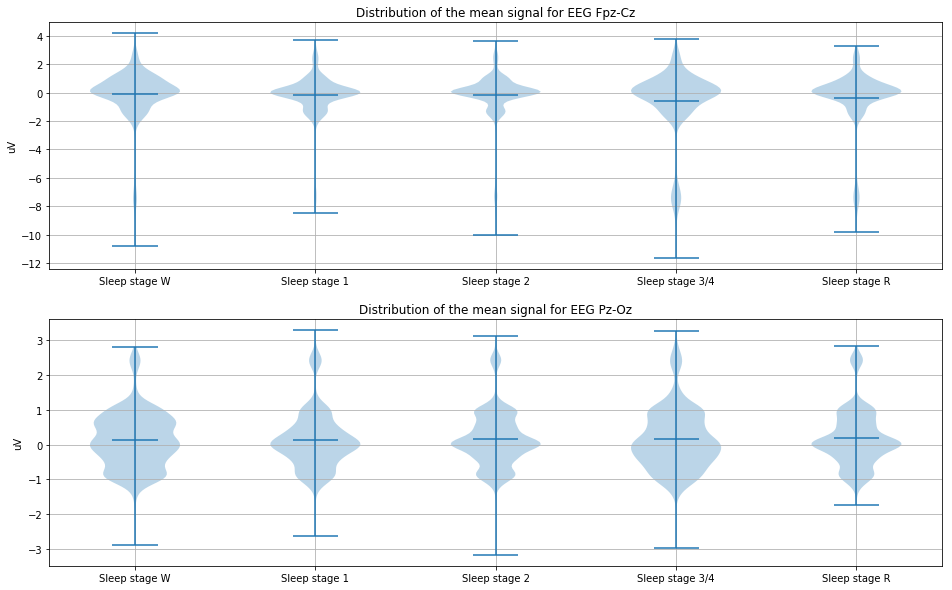

In [50]:
plot_time_domain_distribution(epochs_df, measure_type='mean', unit_label="uV")

#### II - Distribution of the standard deviation of the signal
___

We plot the distribution of the standard deviation values of all epochs. We can see the mean value of the standard deviation of the time domain signal is quite different accross the different sleep stages, as we expected from [the stated paper from Koley](https://doi.org/10.1016/j.compbiomed.2012.09.012).

We can therefore expect the standard deviation of a time domain signal to discriminate the sleep stage classification.

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


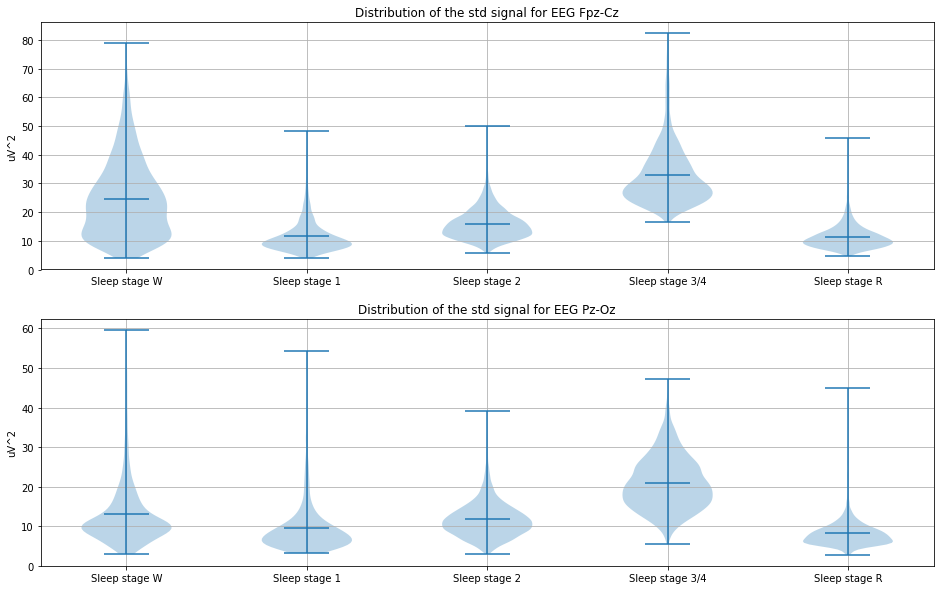

In [51]:
plot_time_domain_distribution(epochs_df, measure_type='std', unit_label="uV^2")

#### III - Distribution of the skewness of the signal
___

We plot the distribution of the skewness value of all epochs. As with the distribution of the mean signal, whereas the mean and the distribution form is quite the same accross sleep stage scores, we assume the added information of this parameter is probably not significant.

Note: skewness does not have a unit [[source]](https://brownmath.com/stat/shape.htm).

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


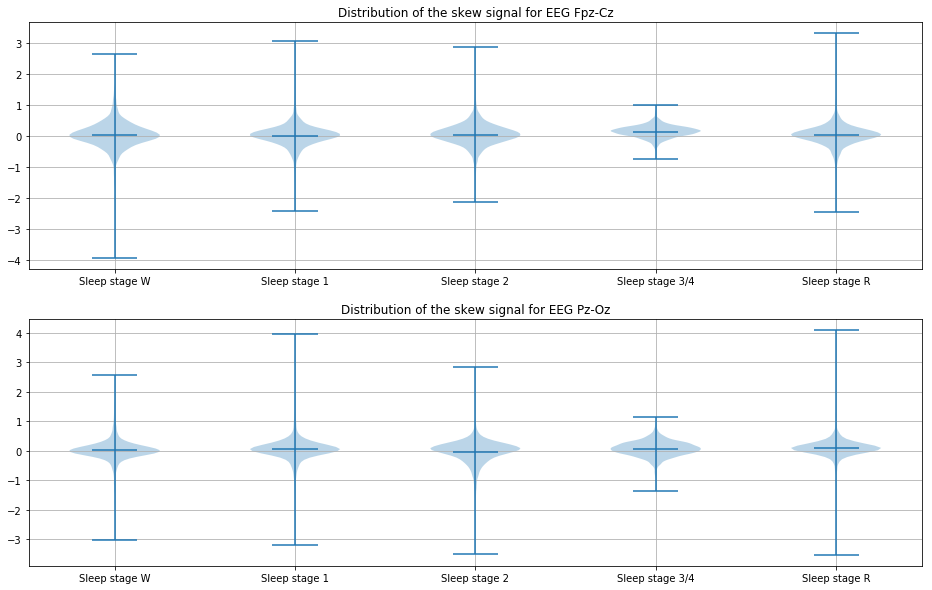

In [52]:
plot_time_domain_distribution(epochs_df, measure_type='skew')

#### IV - Distribution of the kurtosis of the signal
___

We plot the distribution of the kurtosis value of all epochs. The same can be conclude as with the skewness, for the same observed reasons.

Note: kurtosis does not have a unit [[source]](https://brownmath.com/stat/shape.htm).

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


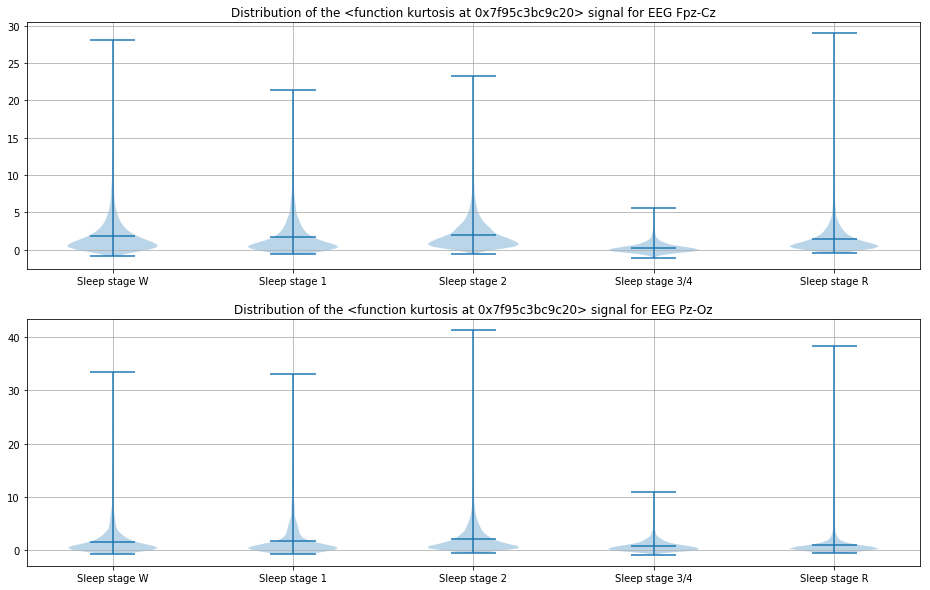

In [53]:
plot_time_domain_distribution(epochs_df, measure_type=kurtosis)

Note that statistical moments could be calculated on subbands of the signal and could give more specific results when targetting subbands.

### b. Zero crossing rate
___

It is defined as the number of time the signal crosses the reference line, which, in our case, is the mean. For each epoch, we will compute the number of time two consecutive data points lies apart of the line determined by the mean. The zero crossing rate is said to be able to distinguish sleep spindles, which are observed during sleep stage 2 [[source]](https://doi.org/10.1016/j.compbiomed.2012.09.012). 



In [54]:
def get_crossing_rate_with_windows(epoch_observations, nb_windows_per_epoch=15):
    """
    Calculates the median crossing rate for `nb_windows_per_epoch` subwindows within a 30s epoch.
    Returns the maximum crossing rate accross all subwindows.
    
    epoch_observations: All data points are expected to be consecutive in time,
        and correspond to all observed potentials (uV) within a 30s epoch.
    nb_windows_per_epoch: Specify how many subwindows to check within the 30s epochs
    """
    nb_points_per_window = len(epoch_observations)/nb_windows_per_epoch # Nb of points in each two second window
    mean_value = epoch_observations.mean()
    cross_occurences = [0]*nb_windows_per_epoch
    
    for i, (first, second) in enumerate(zip(epoch_observations, epoch_observations[1:])):
        if (first > mean_value and second < mean_value) or \
           (first < mean_value and second > mean_value):
            cross_occurences[int(i//nb_points_per_window)] += 1
    
    return np.max(cross_occurences)

def get_crossing_rate(epoch_observations):
    """
    Calculates the median crossing rate for a 30s epoch.
    
    epoch_observations: All data points are expected to be consecutive in time,
        and correspond to all observed potentials (uV) within a 30s epoch.
    """
    mean_value = epoch_observations.mean()
    cross_occurences = 0
    
    for first, second in zip(epoch_observations, epoch_observations[1:]):
        if (first > mean_value and second < mean_value) or \
           (first < mean_value and second > mean_value):
            cross_occurences += 1
    
    return cross_occurences

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


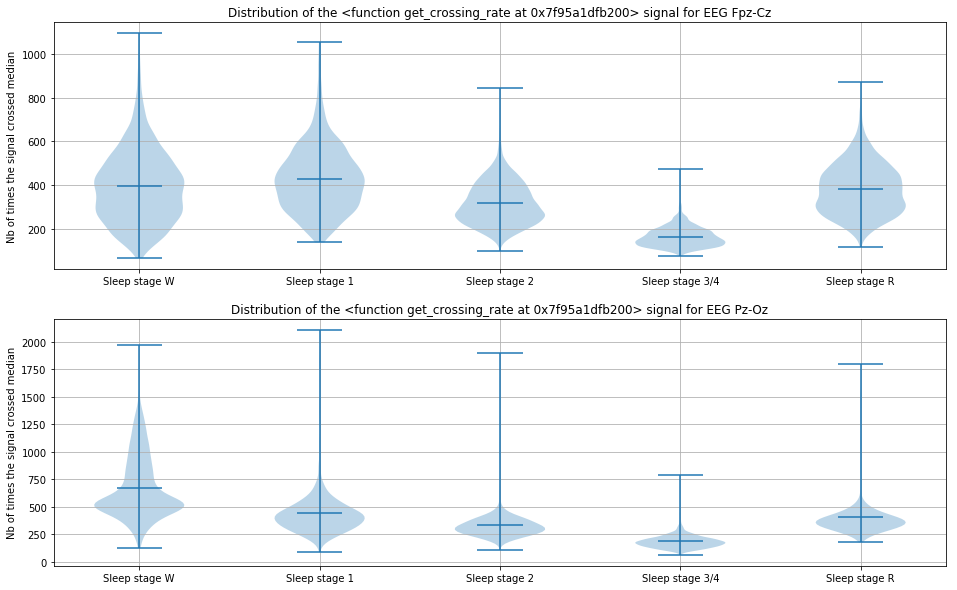

CPU times: user 7min 14s, sys: 21.7 s, total: 7min 35s
Wall time: 12min 38s


In [55]:
%%time

plot_time_domain_distribution(epochs_df, measure_type=get_crossing_rate, unit_label="Nb of times the signal crossed median")

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


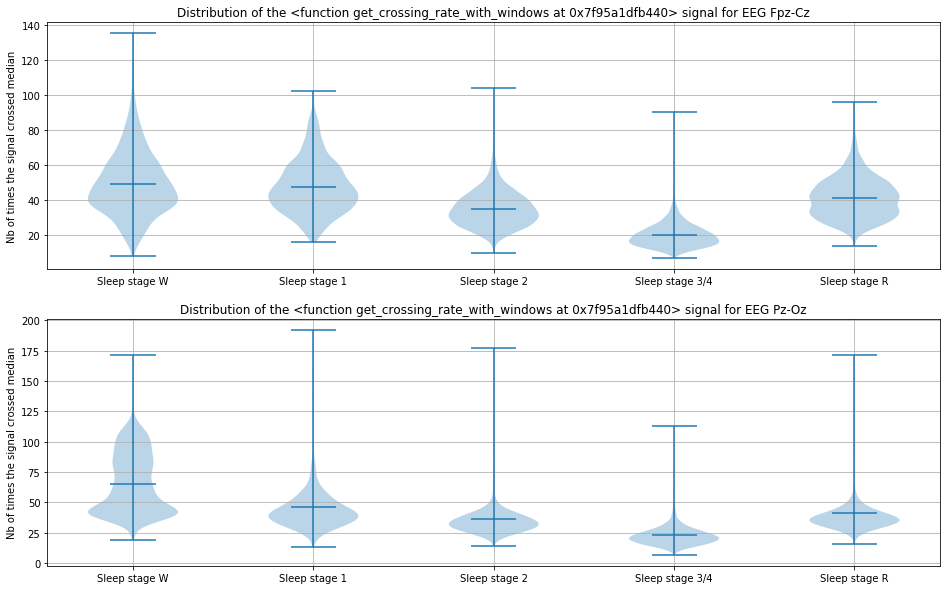

In [56]:
plot_time_domain_distribution(epochs_df, measure_type=get_crossing_rate_with_windows, unit_label="Nb of times the signal crossed median")

We can see this parameter discriminate epochs according to their sleep stages, because the mean doesn't overlap. It may not be significant as to describe epochs when the subject is awake, because the distribution looks flat.

### c. Hjorth parameters
___

Hjorth parameters are often used as features to describe EEG signals (via wiki). The formulas are taken from this paper [[source]](https://www.doi.org/10.1155/2011/406391) and this paper [[source]](https://www.doi.org/10.1109/TBME.2005.869773). They are calculated on all of the 30s epoch. The parameters are:

- Hjorth activity

    Corresponds to the signal power, whereas the variance of the signal. It was already observed at section 1.a.

- Hjorth mobility

$$mobility = \sqrt{\frac{\sigma(\bf{x}')}{\sigma(\bf{x})}} = \sqrt{\frac{\sum{(x_i - x_{i-1})}/N}{\sum{(x_i)}/N}}$$    
    
- Hjorth complexity

$$complexity = \frac{mobility(\bf{x}')}{mobility(\bf{x})} = \frac{\sqrt{\sum{(x_i - 2x_{i-1} + x_{i-2})^2\sum{x_i}}}}{\sum{(x_i - x_{i-1})}}$$


In [57]:
# Code took from https://github.com/forrestbao/pyeeg/blob/master/pyeeg/hjorth_mobility_complexity.py
# to calculate hjorth parameters

def get_hjorth_mobility(signal):
    """
    Calculates the hjorth mobility for a 30s epoch.
    
    signal: All data points are expected to be consecutive in time,
        and correspond to all observed potentials (uV) within a 30s epoch.
    """
    signal = signal.tolist()
    differential_signal = np.diff(signal).tolist()
    
    differential_signal.insert(0, signal[0])  # pad the first difference
    differential_signal = np.array(differential_signal)

    n = len(signal)

    M2 = float(sum(differential_signal ** 2)) / n
    TP = sum(np.array(signal) ** 2)

    return np.sqrt(M2 / TP)

def get_hjorth_complexity(signal):
    """
    Calculates the hjorth mobility for a 30s epoch.
    
    signal: All data points are expected to be consecutive in time,
        and correspond to all observed potentials (uV) within a 30s epoch.
    """
    signal = signal.tolist()
    differential_signal = np.diff(signal).tolist()
    
    differential_signal.insert(0, signal[0])  # pad the first difference
    differential_signal = np.array(differential_signal)

    n = len(signal)

    M2 = float(sum(differential_signal ** 2)) / n
    TP = sum(np.array(signal) ** 2)

    M4 = 0
    for i in range(1, len(differential_signal)):
        M4 += (differential_signal[i] - differential_signal[i - 1]) ** 2
    M4 = M4 / n

    return np.sqrt(float(M4) * TP / M2 / M2)

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


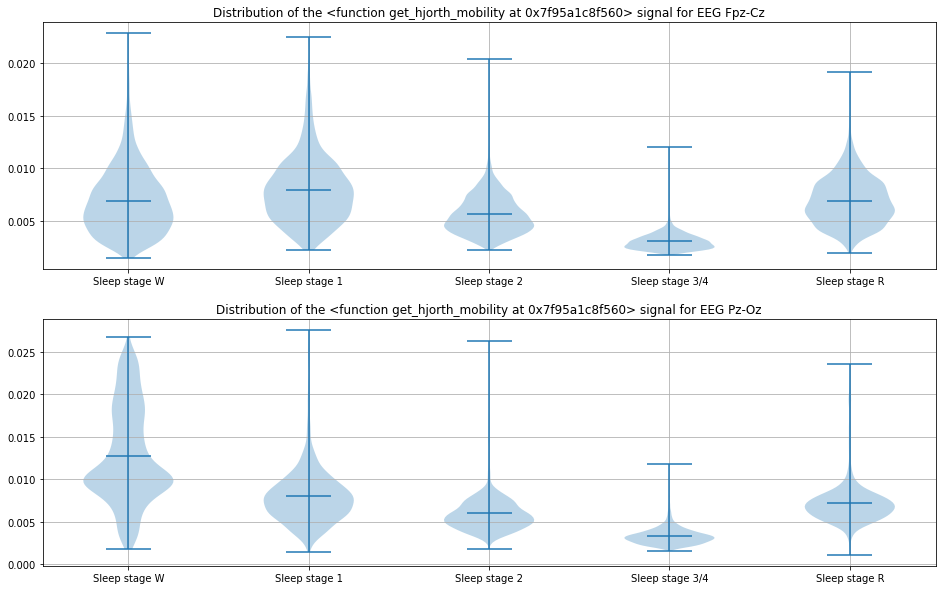

CPU times: user 7min 17s, sys: 21.8 s, total: 7min 38s
Wall time: 12min 13s


In [58]:
%%time

plot_time_domain_distribution(epochs_df, measure_type=get_hjorth_mobility)

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


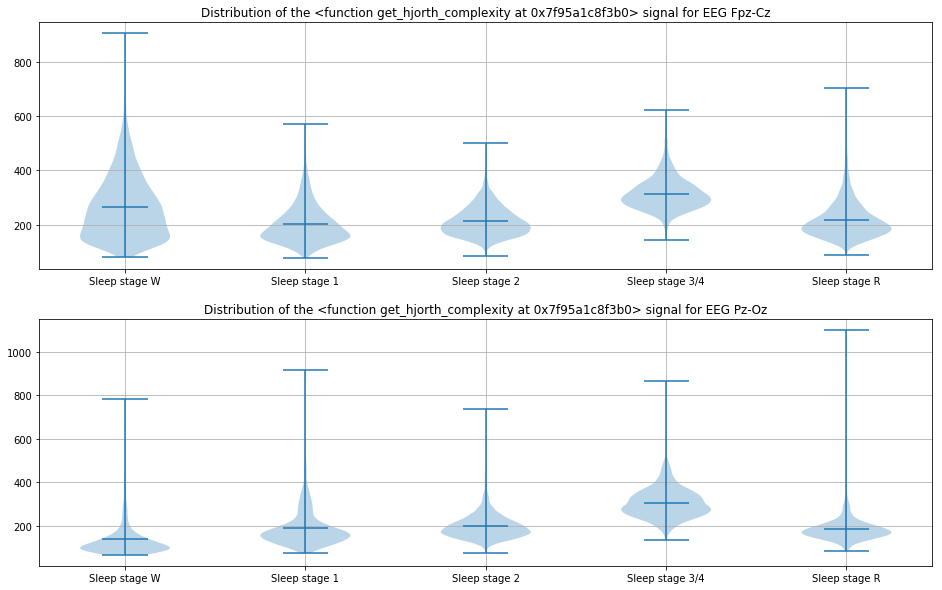

CPU times: user 14min 7s, sys: 22.3 s, total: 14min 30s
Wall time: 23min 17s


In [59]:
%%time

plot_time_domain_distribution(epochs_df, measure_type=get_hjorth_complexity)

Both parameters seem discriminating, notably the mobility for the second channel. However, with the current implementation, the calculation of the hjort complexity can take time, even with a small number of epochs. 

## Analyzing non-linear features
___

Without the EOG channel as an input to our classifier, sleep stages that are the hardest to distinguish are the REM and sleep stage 1. As it is mentionned in this article [[source]](https://doi.org/10.1016/j.compbiomed.2012.09.012), they can be discriminated with the following features:

> The non-linear parameters ApEn and LZC found to be effective in distinguishing between the two hardly distinguishable stages: S1 and REM.

We chose to use ApEn since it is more used in automatic sleep stage score than LZC [[source]](https://www.doi.org/10.3390/e18090272).

### Approximate entropy
___

As with Shannon entropy, this feature discribes the "randomness" of the signal, the disorder or uncertainty of the values that compose the signal. On the other hand, the difference between Shannon and Approximate entropies is that the first considers the distribution of the signal, whereas the latter observes sequence reccurence [[source]](https://doi.org/10.3389/fninf.2013.00033). It is then more appropriate to use approximate entropy on signals of shorter lengths.


I also used `entroPy` to calculate ApEn.

The basic algorithm to calculate ApEn is O(N^2), which is quite long. I've found [this paper](https://doi.org/10.1016/j.cmpb.2008.02.008), which includes a good definition of the feature, that reduces the compute time, which could be useful if we include this feature.

Approximate entropy uses three parameters:
- Window size $m$
       
    Defines the length of the subwindows that will be compared. According to [this paper](https://www.frontiersin.org/articles/10.3389/fninf.2013.00033/full), the suggested value for EEG signals found accross multiple other papers is **2**.
- Distance $r$

    Defines the minimum distance between two data points to be considered *similar*. We set it to 0.2 times the standard deviation of the signal; $r = 0.2*\sigma(X)$.

- Total signal length $N$

    Defines the length of the entire observed signal. It typically is between 75 and 5000 [[source]](http://doi.org/10.1177/155005940503600106). In our case, we have $N = 100 hz *30s = 3000$, which is normal.

In [60]:
def get_approximate_entropy(signal):
    """
    Calculates the approximate entropy for a 30s epoch.
    
    signal: All data points are expected to be consecutive in time,
        and correspond to all observed potentials (uV) within a 30s epoch.
        
    By using the entroPy library, we cannot set the `r` parameter. Though, it uses the same definition
    as we expected to use, because it was conceived to be used for EEG signals.
    """
    signal = signal.to_numpy()

    M = 3

    return entropy.app_entropy(signal, order=M)

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


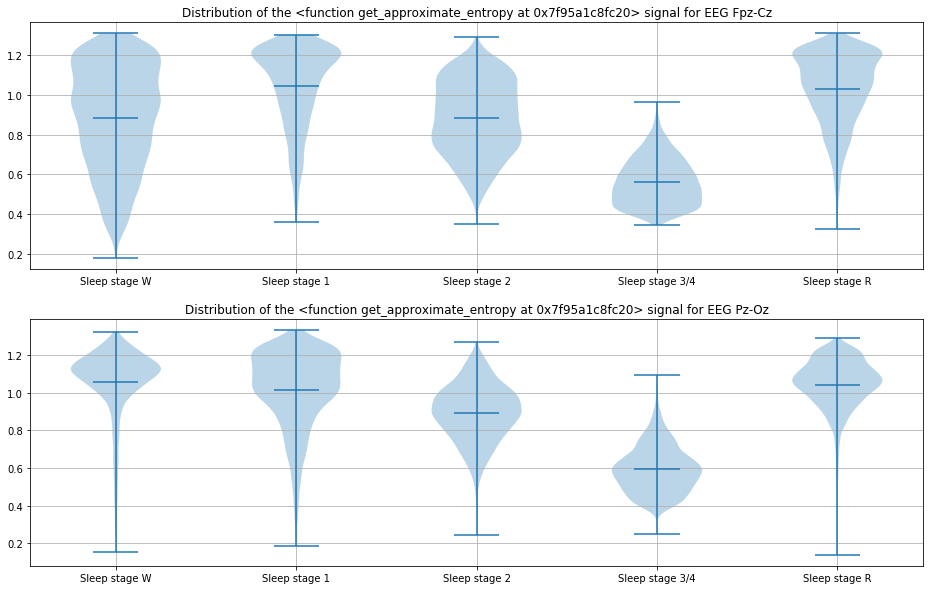

CPU times: user 1h 20min 41s, sys: 23.8 s, total: 1h 21min 5s
Wall time: 2h 7min 55s


In [61]:
%%time

plot_time_domain_distribution(epochs_df, measure_type=get_approximate_entropy)

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


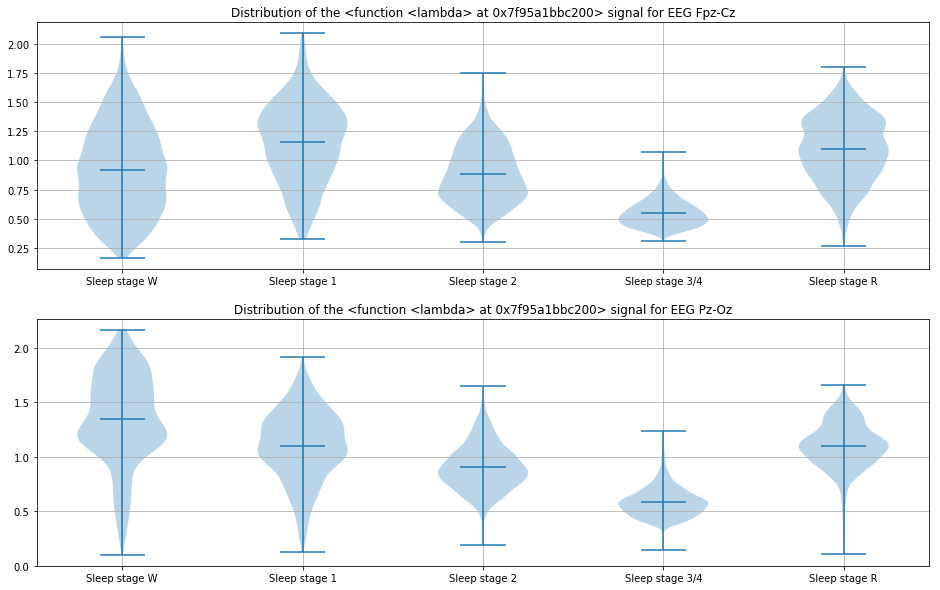

CPU times: user 1h 27min 17s, sys: 26.3 s, total: 1h 27min 43s
Wall time: 2h 11min 14s


In [62]:
%%time
plot_time_domain_distribution(epochs_df, measure_type=lambda signal: entropy.sample_entropy(signal, order=2))

# **Analizing time domain features with δ, θ, α, β and γ frequency band decomposition**
___

We'll apply 5 butterworth band-pass filters on our time series.

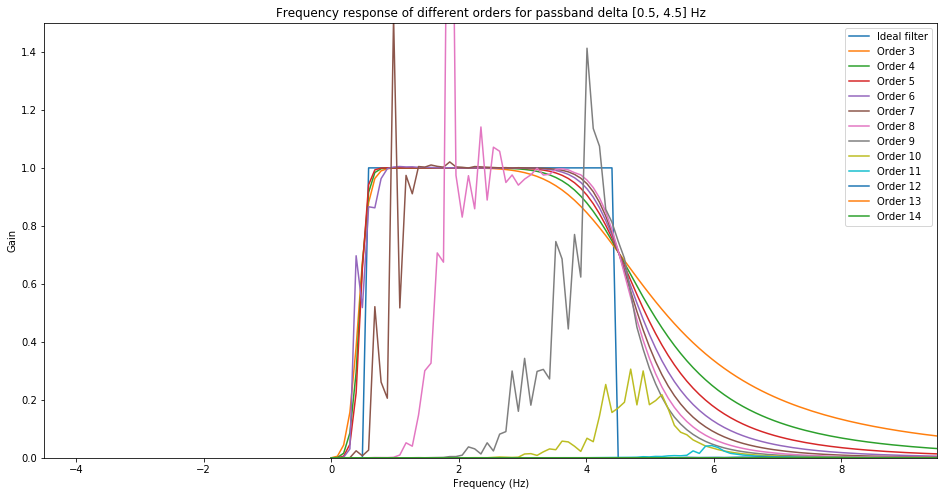

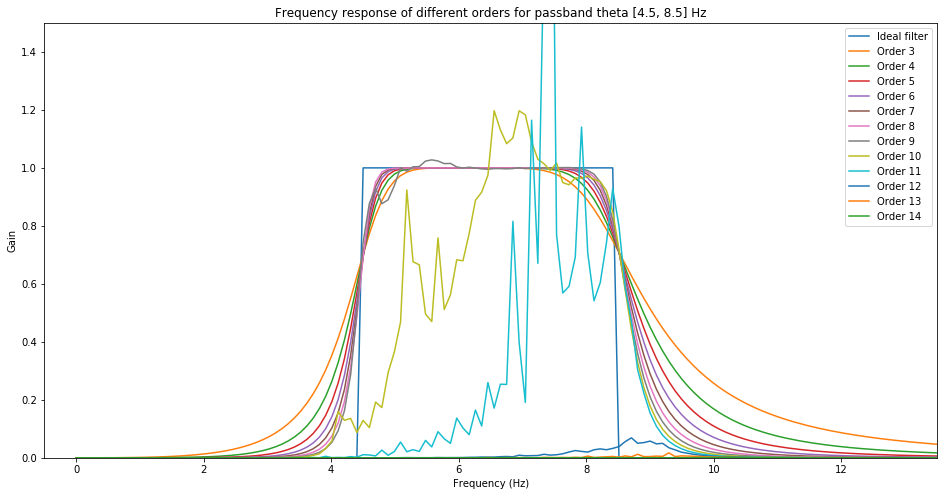

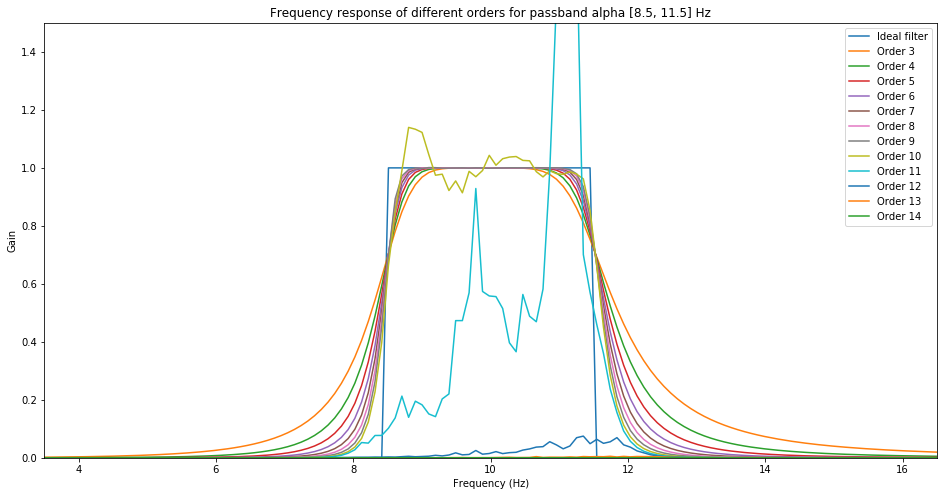

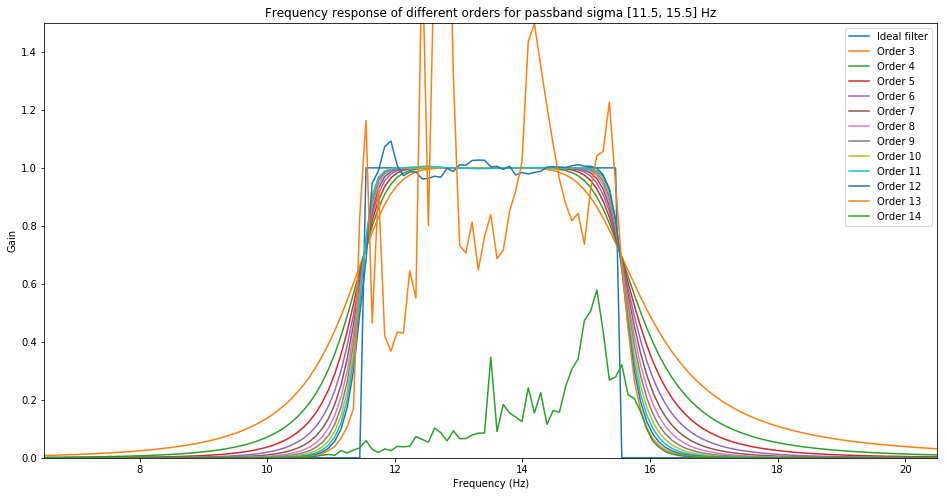

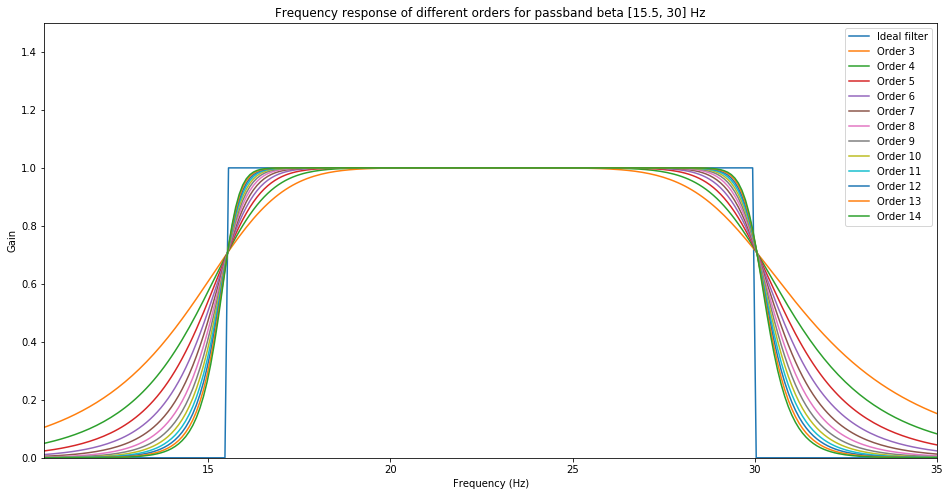

In [63]:
NYQUIST_FREQ = SAMPLING_FREQ/2
WOR_N = 512

epochs_sub_bands = dict.fromkeys(FREQ_BANDS.keys())
kernels = dict.fromkeys(FREQ_BANDS.keys())

for key, freq_range in FREQ_BANDS.items():
    fig, ax = plt.subplots(figsize = (16, 8))
    lower_bound = freq_range[0]/NYQUIST_FREQ
    upper_bound = freq_range[1]/NYQUIST_FREQ
    hz = np.linspace(0, NYQUIST_FREQ, WOR_N)
    ideal_filter = [1 if freq_range[0] <= f <= freq_range[1] else 0 for f in hz]
    ax.plot(hz, ideal_filter, label="Ideal filter")
    kernels[key] = {}
    for order in range(3,15):
        b, a = scipy.signal.butter(order, [lower_bound, upper_bound], btype='bandpass')
        w, h = scipy.signal.freqz(b, a, worN=WOR_N)
        ax.plot(hz, abs(h), label=f"Order {order}")
        ax.set_ylim([0, 1.5])
        ax.set_xlim([freq_range[0] - 5, freq_range[1] + 5])
        kernels[key][order] = (b, a)

    ax.legend()
    ax.set_title(f"Frequency response of different orders for passband {key} {freq_range} Hz")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Gain")
    plt.show()

We then choose the order that has the the best frequency response for each of our bandpass.

In [64]:
%%time
ORDERS = {
    'delta': 5,
    'theta': 8,
    'alpha': 9,
    'sigma': 9,
    'beta': 14
}

CPU times: user 12 µs, sys: 1e+03 ns, total: 13 µs
Wall time: 21.5 µs


Let's use mne to apply this filter directly on the epochs object.

In [65]:
%%time
for key, freq_range in FREQ_BANDS.items():
    l_freq = freq_range[0]/NYQUIST_FREQ
    h_freq = freq_range[1]/NYQUIST_FREQ
    b = kernels[key][ORDERS[key]][0]
    a = kernels[key][ORDERS[key]][1]
    epochs_sub_bands[key] = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', n_jobs=-1, iir_params = {'order': order, 'ftype': 'butter','a': a,'b': b}, verbose=False)

CPU times: user 2min 19s, sys: 11.9 s, total: 2min 31s
Wall time: 5min 43s


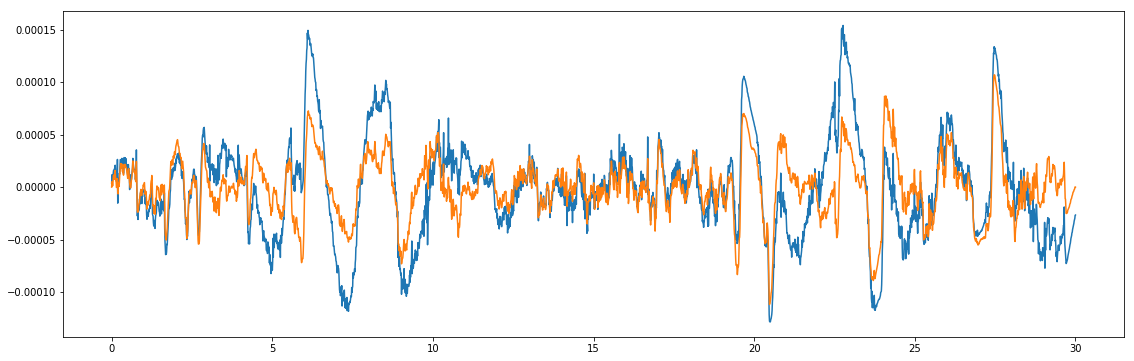

In [66]:
fig, ax = plt.subplots(figsize=(19,6))

original_epoch = epochs['Sleep stage W'][0].get_data().squeeze()[0]
x = np.linspace(0.0, EPOCH_DURATION, len(original_epoch))
ax.plot(x, original_epoch, label="Original signal")

reconstituted_signal = np.zeros(len(original_epoch))
for key in FREQ_BANDS.keys():
    reconstituted_signal += epochs_sub_bands[key]['Sleep stage W'][0].get_data().squeeze()[0]

ax.plot(x, reconstituted_signal, label="Reconstituted signal")

This reconstructed signal from all the bands looks a lot like the original signal. Since we filtered the DC component, the reconstructed signal has an offset. Also, we removed all frequencies over 30 Hz so it introduces small differences. We can conclude the filtering works well and did not alter our signal too much!

# MMD
___

https://www.researchgate.net/publication/306391958_Sleep_Stage_Classification_Using_EEG_Signal_Analysis_A_Comprehensive_Survey_and_New_Investigation

We'll use a sliding window and calculate the distance between our maximum and minimum point in this window. We'll then average this data for all our epoch. One issue by proceding like this is that the use of a sliding window can introduce some edge effects at the beginning and at the end of every epoch.

In [67]:
EPOCH_LEN = int(EPOCH_DURATION * SAMPLING_FREQ)
SLIDING_WINDOW_LEN = EPOCH_LEN//30

In [68]:
def get_mmd(signal):
    signal = signal.to_numpy()
    mmd = 0
    for i in range(len(signal)):
        subwindow = signal[i:i+SLIDING_WINDOW_LEN]
        max_idx = np.argmax(subwindow)
        min_idx = np.argmin(subwindow)
        mmd += np.sqrt((max_idx - min_idx)**2 + (subwindow[max_idx] - subwindow[min_idx])**2)  # Euclidean distance between max and min value
    return mmd

MMD for the delta subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


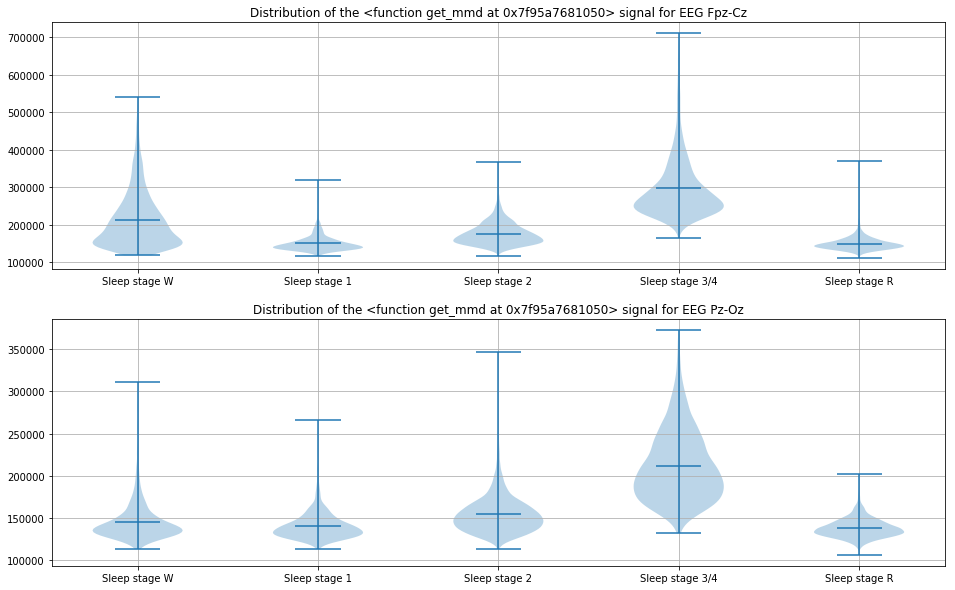

MMD for the theta subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


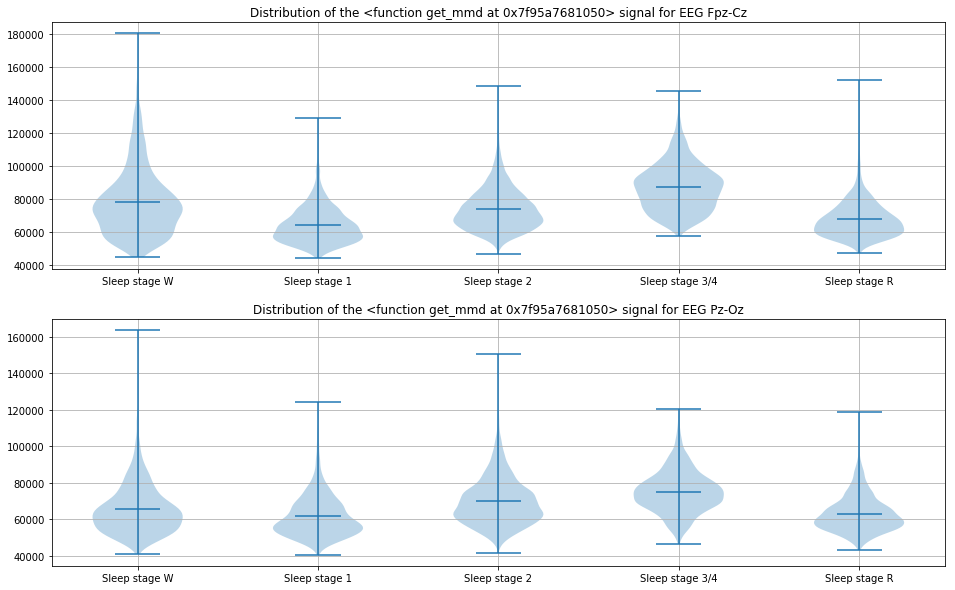

MMD for the alpha subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


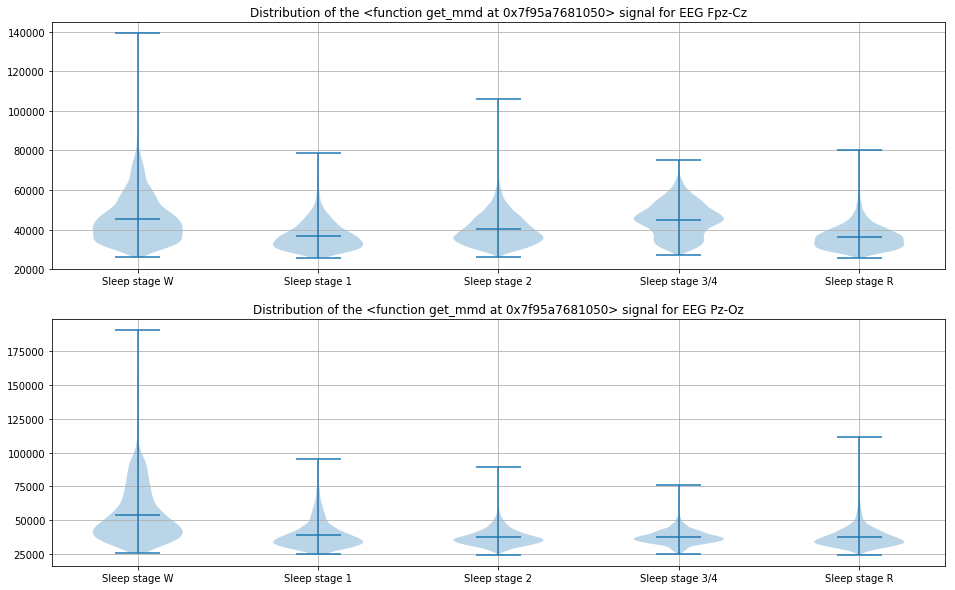

MMD for the sigma subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


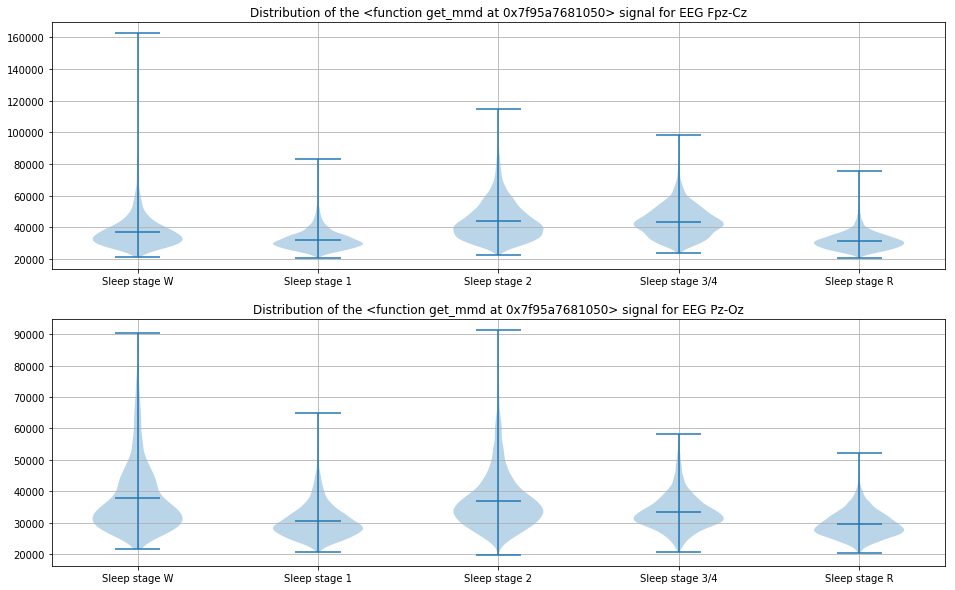

MMD for the beta subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


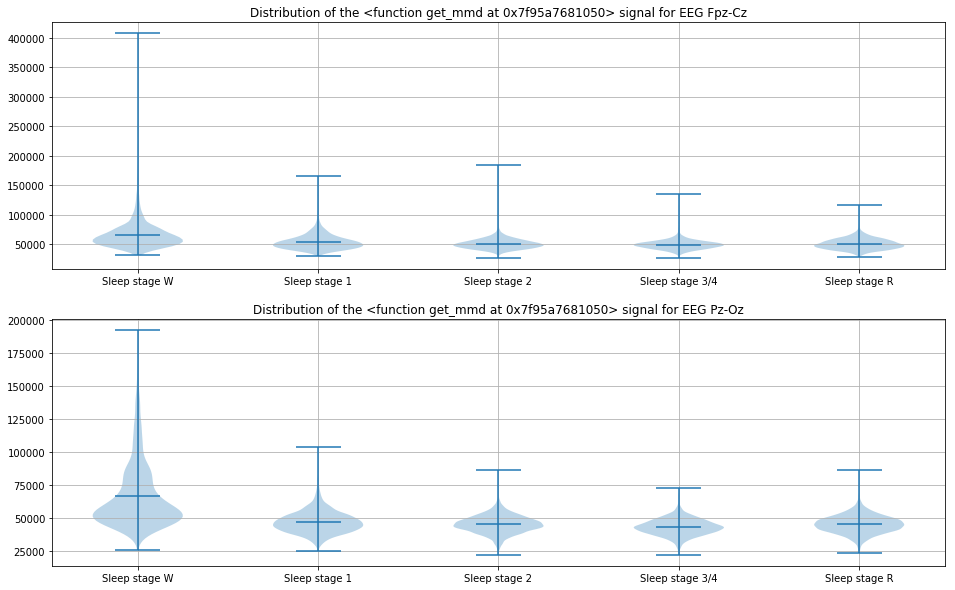

CPU times: user 3h 27min 19s, sys: 3min 43s, total: 3h 31min 2s
Wall time: 4h 49min 6s


In [69]:
%%time

for key in FREQ_BANDS.keys():
    print(f"MMD for the {key} subband")
    plot_time_domain_distribution(epochs_sub_bands[key].to_data_frame(long_format=True, copy=False), measure_type=get_mmd) 

### What we see:
___

MMD is one of our less efficient feature. Also its results are not that good (at least for the way we implemented it).

## Mean energy
___

For a stationery process (and let's suppose we can say that because of Welch's method...), the [average power can simply be interpreted as the second moment (variance) of the signal](https://dsp.stackexchange.com/questions/38757/what-is-the-practical-meaning-of-the-variance-covariance-mean-value). Since the variance was one of the most prominent feature when analyzing our signal, let's compute it for each subband.

Mean energy:

$$ME = \frac{1}{N}\sum_{t=0}^{N} x_t^2$$

where N is the epoch length


In [70]:
def get_mean_energy(signal):
    signal = signal.to_list()
    mean_energy = 0
    for datum in signal:
        mean_energy += datum**2
    return mean_energy/len(signal)

Mean energy for the delta subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


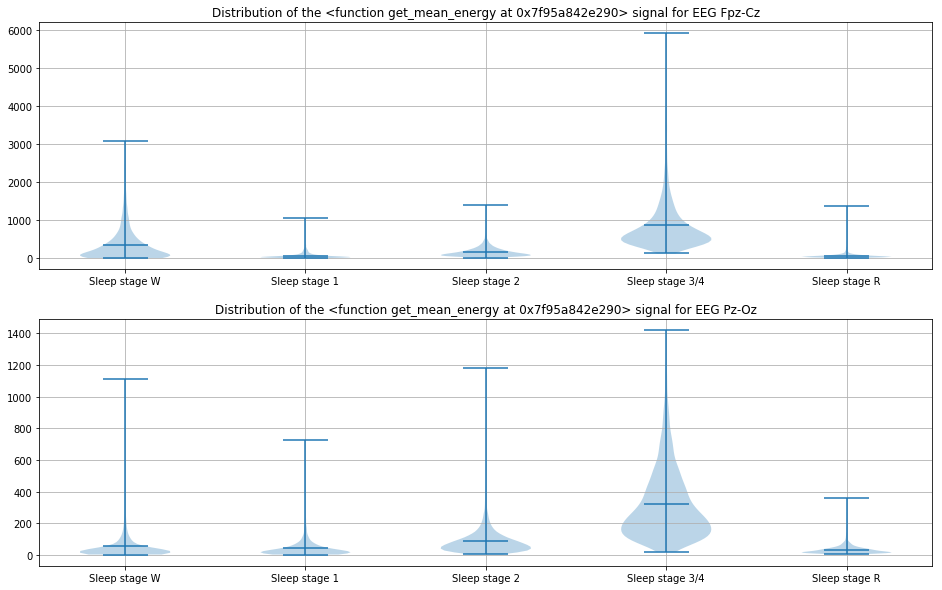

Mean energy for the theta subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


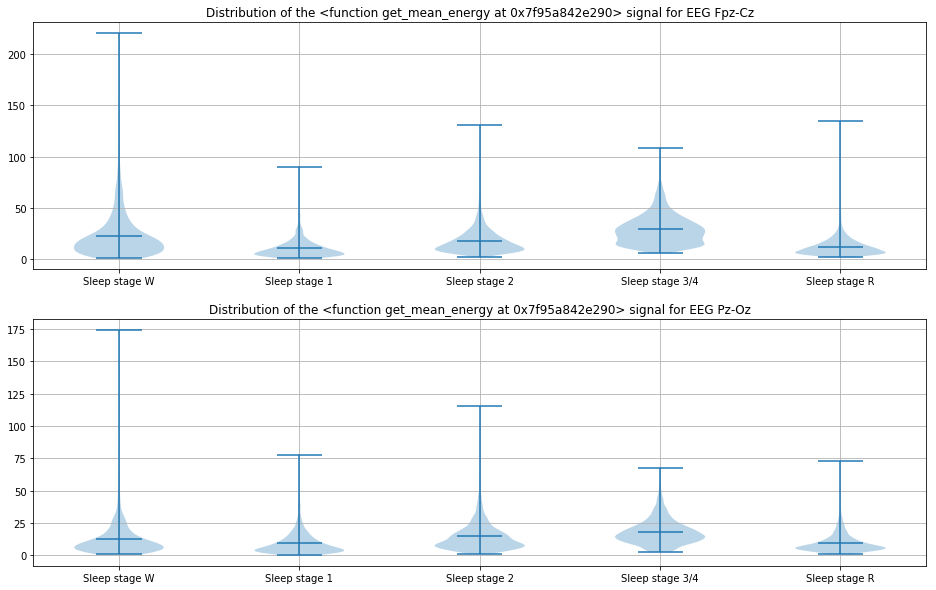

Mean energy for the alpha subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


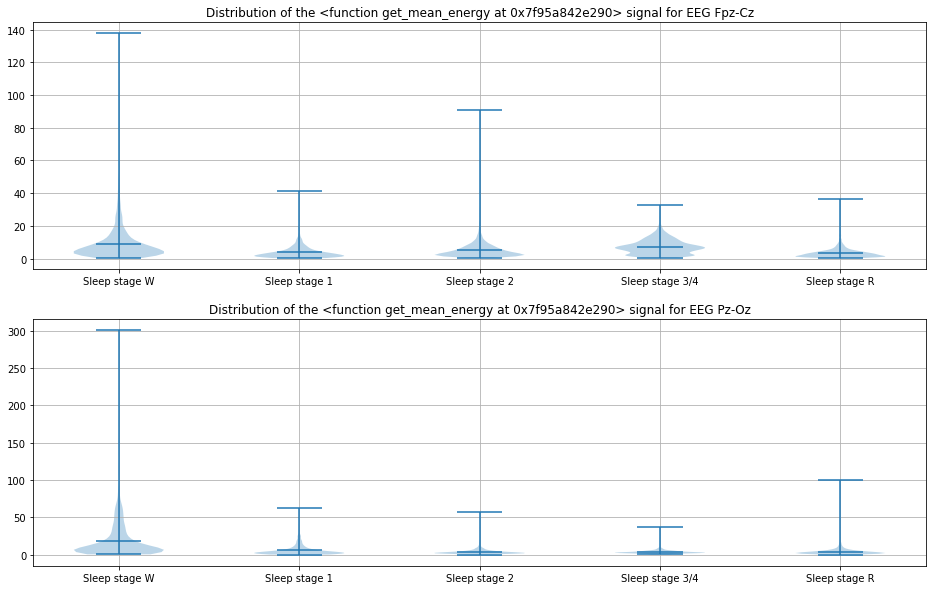

Mean energy for the sigma subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


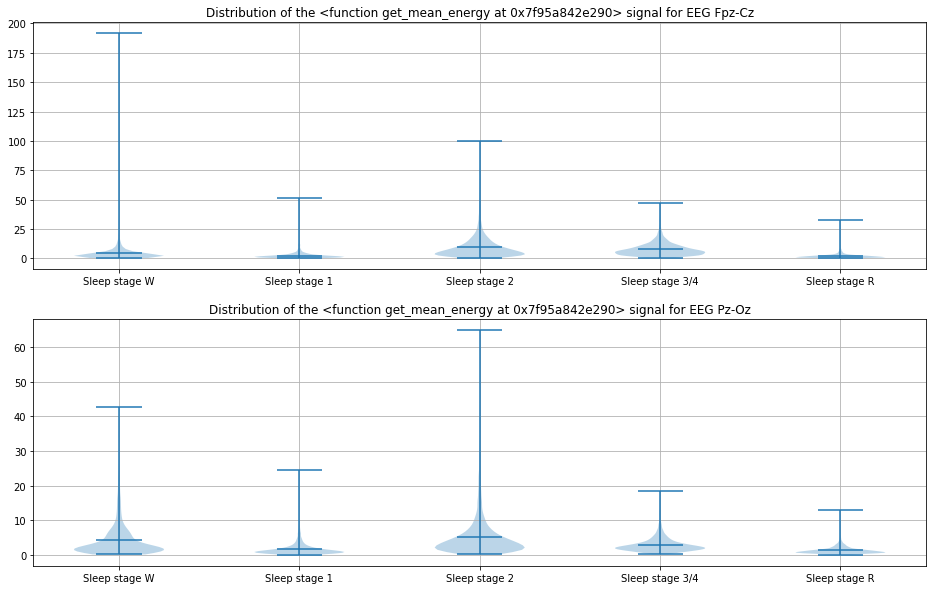

Mean energy for the beta subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


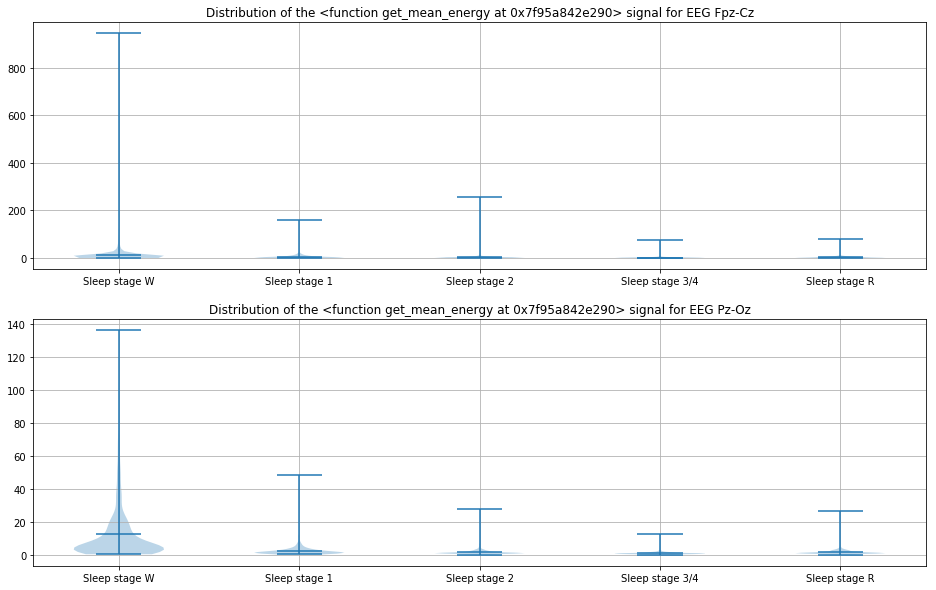

CPU times: user 6min 54s, sys: 1min 25s, total: 8min 19s
Wall time: 8min 31s


In [71]:
%%time

for key, freq_range in FREQ_BANDS.items():
    print(f"Mean energy for the {key} subband")
    plot_time_domain_distribution(epochs_sub_bands[key].to_data_frame(long_format=True, copy=False), measure_type=get_mean_energy) 

### What we see
___

Wonderful! This seems like a great feature because it may help discriminate N1 from REM. See, the distribution of REM is way more narrow than the one of N1. Also, it is possible to discriminate N1 and REM from Wake.

## Mean Taiger-Kaiser energy
___

Mean teager-kaiser energy:

$$MTKE = \frac{1}{N}\sum_{t=1}^{N-1} x_t^2 - x_{t-1} x_{t+1}$$

where N is the epoch length

In [72]:
def get_mean_tkeo(signal):
    signal = signal.to_list()
    mean_tkeo = 0
    for i in range(1, len(signal) - 1):
        tkeo = signal[i]**2 - signal[i-1]*signal[i+1]
        mean_tkeo += tkeo
    return (mean_tkeo/len(signal)-2)

Mean TKEO for the delta subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


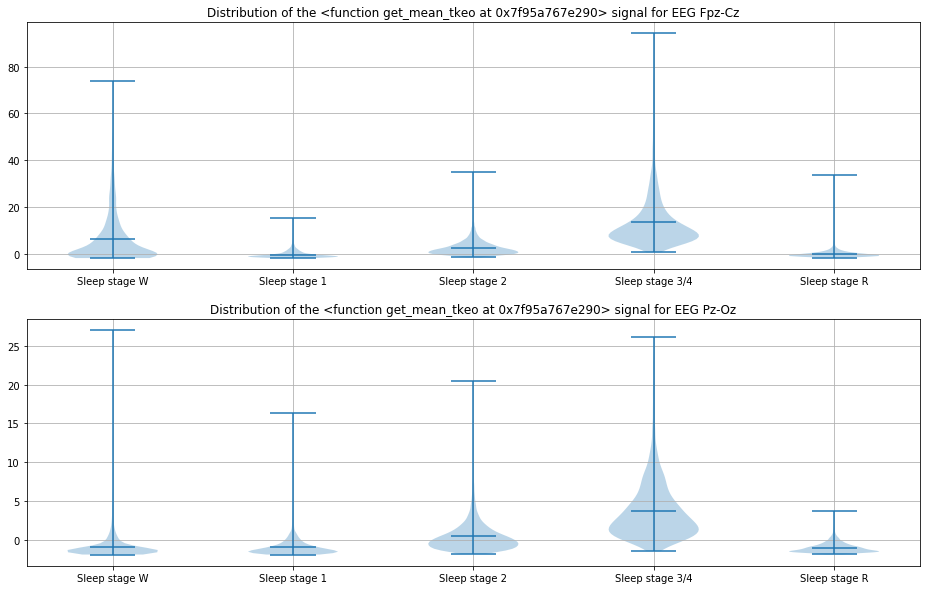

Mean TKEO for the theta subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


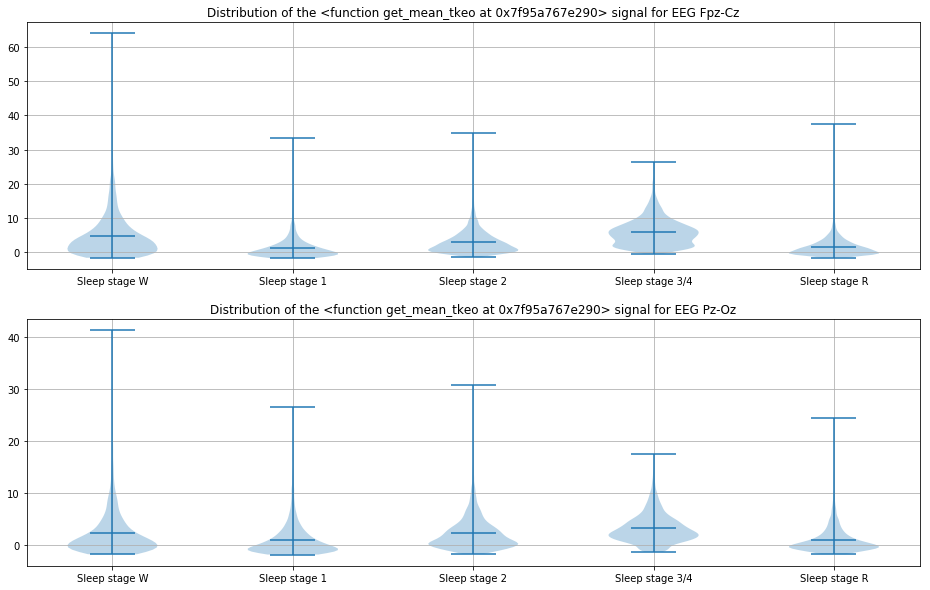

Mean TKEO for the alpha subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


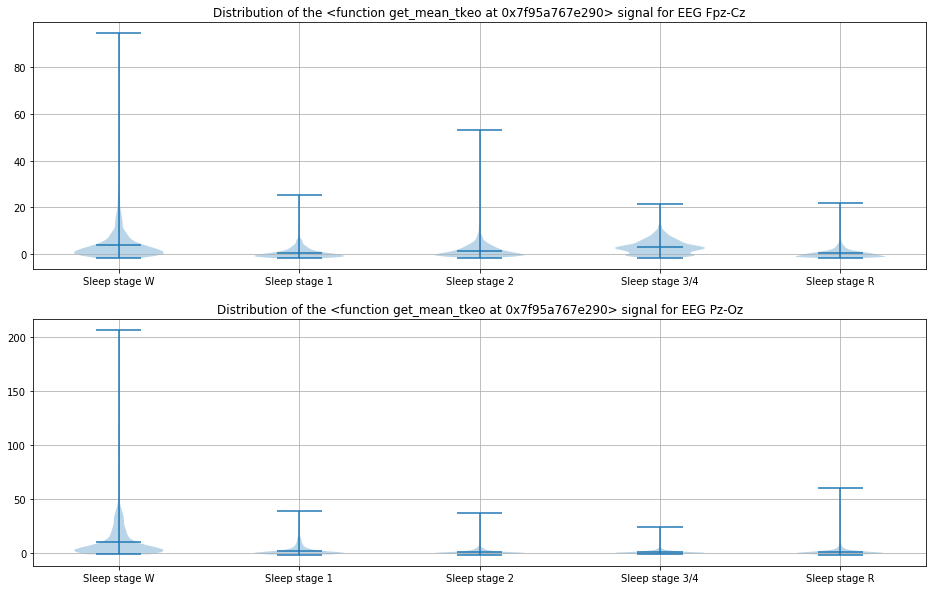

Mean TKEO for the sigma subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


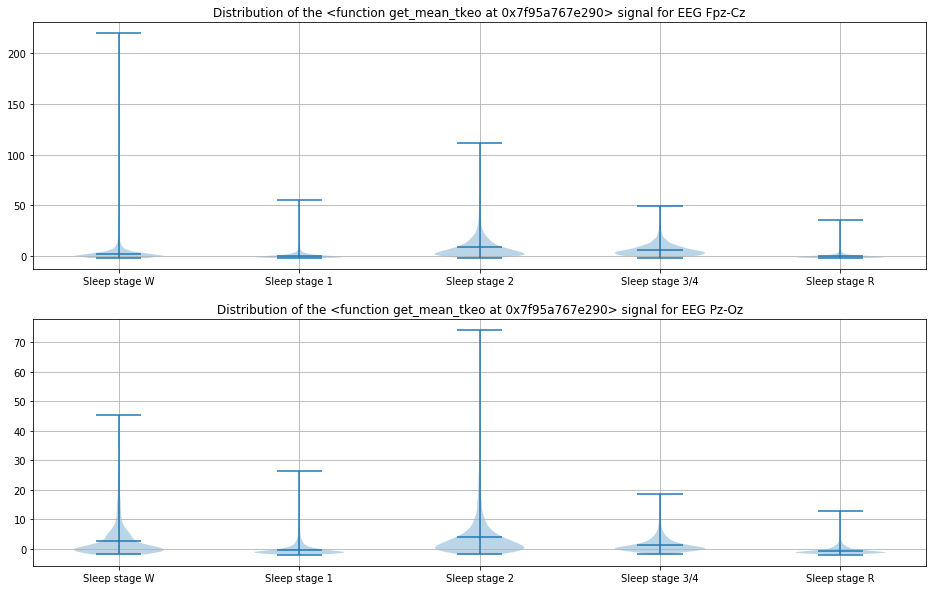

Mean TKEO for the beta subband
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


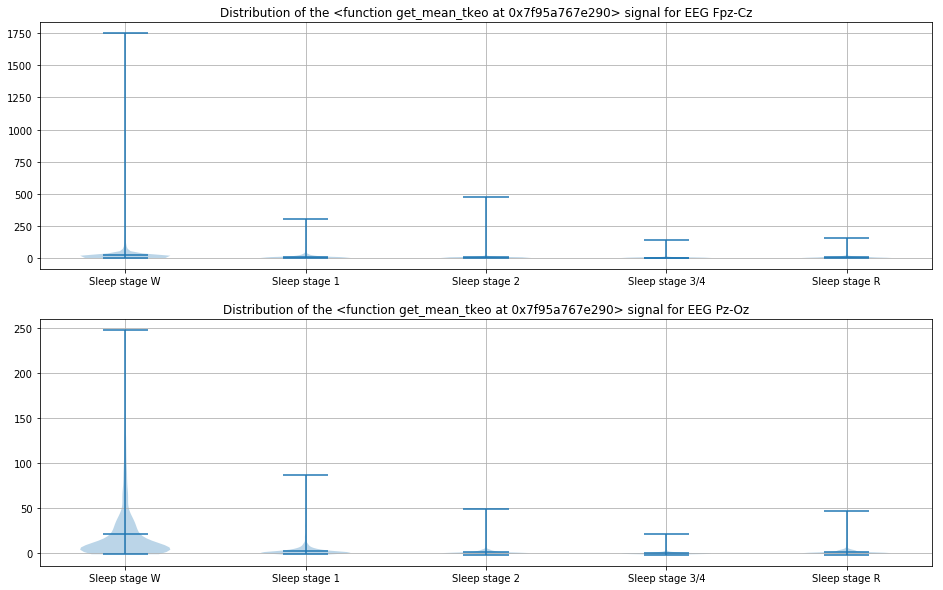

CPU times: user 8min 18s, sys: 2min 21s, total: 10min 39s
Wall time: 10min 52s


In [73]:
%%time

for key in FREQ_BANDS.keys():
    print(f"Mean TKEO for the {key} subband")
    plot_time_domain_distribution(epochs_sub_bands[key].to_data_frame(long_format=True, copy=False), measure_type=get_mean_tkeo) 

### What we see
___

It does not seem like there is a lot of differences between the mean TKE operator and the mean energy of the signal.

## Sleep spindles detection
___

[This blogpost]( https://raphaelvallat.com/spindles.html) shows a precise method to do spindles detection in sleep stage 2. As it is quoting:

>  According to the formal definition by the American Academy of Sleep Medicine (AASM), a sleep spindle is "a train of distinct 11–16 Hz waves, predominant over central EEG derivations and lasting more than 0.5 s".

We'll try to see if spindles detection, with this algorithm occurs more frequently in sleep stage two than the others sleep stages. We use the following function as written by Raphael Vallat but we modified it a little bit to calculate the sum of the spindles durations that are greater than 400 ms.

In [74]:
def spindles_detect(x, sf, thresh=0.25, wlt_params={'nc': 12, 'cf': 'auto'}):
    """Simple spindles detector based on Morlet wavelet.

    Parameters
    ----------
    x : 1D-array
        EEG signal
    sf : float
        Sampling frequency
    thresh : float
        Threshold (0 - 1)
    wlt_params : dict
        Morlet wavelet parameters ::

        'nc' : number of oscillations
        'cf' : central frequency (int or 'auto')

    Returns
    -------
    supra_thresh_bool : 1D-array (boolean)
        Boolean array indicating for each point if it is a spindles or not.
    sp_params : dict
        Spindles parameters dictionnary.
    """
    if wlt_params['cf'] == 'auto':
        # Compute the power spectrum and find the peak 11-16 Hz frequency.
        psd, freqs = psd_array_multitaper(x, sf, fmin=11, fmax=16, verbose=0)
        wlt_params['cf'] = freqs[np.argmax(psd)]
        print('Central frequency: %.2f Hz' % wlt_params['cf'])


    # Compute the wavelet and convolve with data
    wlt = morlet(sf, [wlt_params['cf']], n_cycles=wlt_params['nc'])[0]
    analytic = np.convolve(x, wlt, mode='same')
    phase = np.angle(analytic)

    # Square and normalize the magnitude from 0 to 1 (using the min and max)
    power = np.square(np.abs(analytic))
    norm_power = (power - power.min()) / (power.max() - power.min())

    # Find supra-threshold values and indices
    supra_thresh_bool = norm_power >= thresh
    supra_thresh_idx = np.where(supra_thresh_bool)[0]

    # Extract duration, frequency and amplitude of spindles
    sp = np.split(supra_thresh_idx, np.where(np.diff(supra_thresh_idx) != 1)[0] + 1)
    idx_start_end = np.array([[k[0], k[-1]] for k in sp])
    sp_dur = (np.diff(idx_start_end, axis=1) / sf).flatten() * 1000
    sp_amp, sp_freq = np.zeros(len(sp)), np.zeros(len(sp))
    for i in range(len(sp)):
        sp_amp[i] = np.ptp(detrend(x[sp[i]]))
        sp_freq[i] = np.median((sf / (2 * np.pi) * np.diff(phase[sp[i]])))

    sp_params = {'Duration (ms)' : sp_dur, 'Frequency (Hz)': sp_freq,
                 'Amplitude (uV)': sp_amp}
    
    # Customization
    sp_dur = [delta_t for delta_t in sp_dur if 500 <= delta_t <= 1600]

    return supra_thresh_bool, sp_params, np.sum(sp_dur)

Let's test the code on the provided sample of data.

Central frequency: 12.47 Hz
{'Duration (ms)': array([625., 840.]), 'Frequency (Hz)': array([12.67731712, 12.1907763 ]), 'Amplitude (uV)': array([ 80.31516564, 108.22174332])}


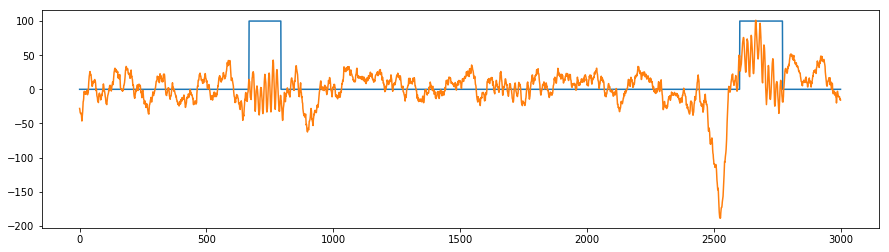

In [75]:
y = np.loadtxt('data/data_spindles_15s_200Hz.txt')
sp_detection_bool, sp_params, _ = spindles_detect(y, 200, thresh=0.25, wlt_params={'nc': 12, 'cf': 'auto'})
print(sp_params)

fig, ax = plt.subplots(figsize=(15, 4))
plt.plot(sp_detection_bool*100)
plt.plot(y)

Wow, we can see that this algorithm work especially well on theoritical spindles!

In [76]:
def total_spindle_detection_time(signal):
    signal = signal.to_numpy()
    _, _, total_spindle_time = spindles_detect(signal, SAMPLING_FREQ, thresh=0.25)
    return total_spindle_time

Central frequency: 11.90 Hz
{'Duration (ms)': array([340., 180., 280., 350., 360., 310., 510., 280., 160.,  90., 120.,
       210., 210., 290.,  50., 240., 170., 450.]), 'Frequency (Hz)': array([11.91286698, 12.01854806, 12.03821799, 12.02570116, 11.67862599,
       11.83298749, 11.89954598, 11.72930279, 11.48675337, 11.8739576 ,
       12.09535282, 11.91234476, 11.92266301, 12.18282238, 11.81264507,
       11.54201192, 12.16580758, 11.68225107]), 'Amplitude (uV)': array([0.47531508, 0.293904  , 0.75369155, 0.22243051, 0.4234551 ,
       0.43983955, 1.53290661, 0.27711508, 0.3853951 , 0.08792488,
       0.31129509, 0.15283501, 0.26553509, 0.29970714, 0.02266625,
       0.37364098, 0.26957142, 0.64479351])}


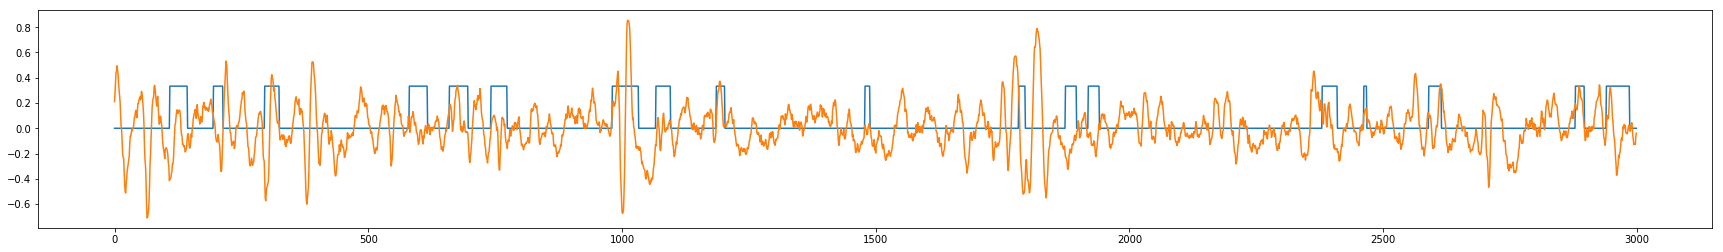

In [77]:
%matplotlib inline
y = epochs['Sleep stage 2'][1].get_data().squeeze()[0]*10000
sp_detection_bool, sp_params, _ = spindles_detect(y, SAMPLING_FREQ, thresh=0.25)
print(sp_params)

fig, ax = plt.subplots(figsize=(30, 4))
plt.plot(sp_detection_bool/3)
plt.plot(y)

Unfortunately, our spindle detection algorithm seems to detect other things than wavelets in our example epoch. But still, let's see if it detects a different number of spindle time accross all our epochs.

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


/home/william/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/william/.local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


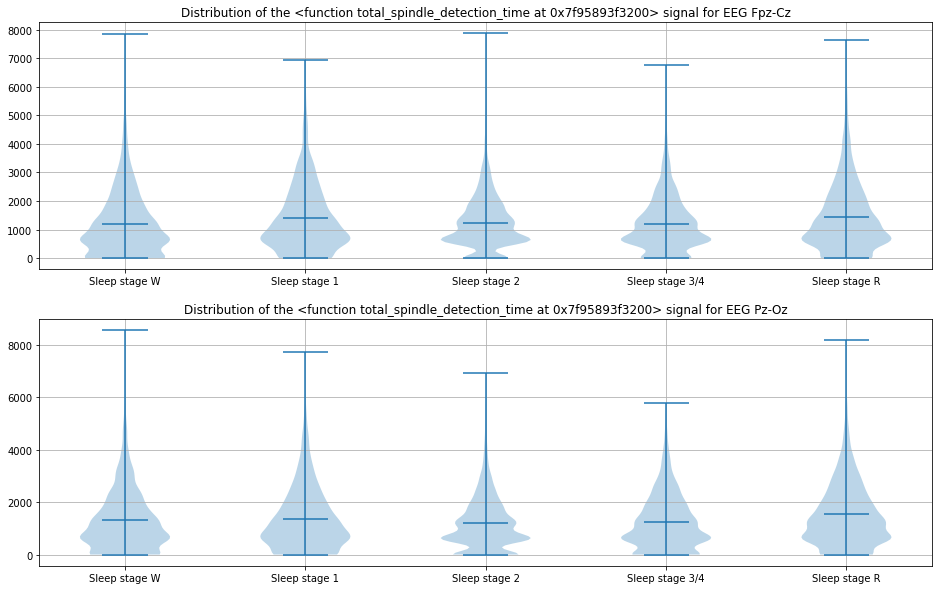

CPU times: user 2min 50s, sys: 7.49 s, total: 2min 57s
Wall time: 3min 2s


In [78]:
%%time

plot_time_domain_distribution(epochs_df, measure_type=total_spindle_detection_time)

### What we see
___

It looks like this spindle detection algorithm is simply not working for our data as it is right now. And even if it was working, it is not helping us to know what stage we are looking at.

# **Difference in sleep stages according to age and gender**
___

Since the subject of the study from which was generated our dataset is about how age and sex affects sleep, it can be interesting to see if there's is any difference in sleep stage distribution when filtered by the age and the gender of the subject.

### Age
___

In [79]:
print("Minimum age is:", df_subject_information.age.min(), "y/o")
print("Maximum age is:", df_subject_information.age.max(), "y/o")

Minimum age is: 25 y/o
Maximum age is: 101 y/o


We'll first calculate the total slept time (without insomnia).

In [80]:
df_subject_information
NON_SLEEP_STAGES = ['Sleep stage W', 'Sleep stage ?', 'Movement time']
for i in range(len(df_subject_information)):
    annotations = mne.read_annotations(subject_files[i][1])
    sleep_latency = annotations[0]['duration'] - df_subject_information.loc[i, 'LightsOffSecond'] 
    df_subject_information.loc[i, 'SleepLatency'] = sleep_latency
        
    df_subject_information.loc[i, 'TotalSleptTime'] = np.sum([annotation['duration'] for annotation in annotations if annotation['description'] not in NON_SLEEP_STAGES])
    df_subject_information.loc[i, 'TotalN1'] = np.sum([annotation['duration'] for annotation in annotations if annotation['description'] == 'Sleep stage 1'])
    df_subject_information.loc[i, 'TotalN2'] = np.sum([annotation['duration'] for annotation in annotations if annotation['description'] == 'Sleep stage 2'])
    df_subject_information.loc[i, 'TotalN3'] = np.sum([annotation['duration'] for annotation in annotations if annotation['description'] in ['Sleep stage 3', 'Sleep stage 4']])
    df_subject_information.loc[i, 'TotalR'] = np.sum([annotation['duration'] for annotation in annotations if annotation['description'] == 'Sleep stage R'])
    df_subject_information.loc[i, 'NbTransitionStade'] = len([annotation for annotation in annotations if annotation['description'] not in ['Sleep stage ?', 'Movement time']])
df_subject_information

subject  night  age  sex           LightsOff         StartRecord  \
0          0      1   33    1 1989-04-25 00:38:00 1989-04-24 16:13:00   
1          0      2   33    1 1989-04-25 21:57:00 1989-04-25 14:50:00   
2          1      1   33    1 1989-03-29 22:44:00 1989-03-29 16:49:00   
3          1      2   33    1 1989-03-30 22:15:00 1989-03-30 17:00:00   
4          2      1   26    1 1989-04-05 22:50:00 1989-04-05 16:48:00   
..       ...    ...  ...  ...                 ...                 ...   
148       80      2   54    1 1991-09-17 23:18:00 1991-09-17 14:55:00   
149       81      1   57    1 1991-09-23 22:00:00 1991-09-23 15:17:00   
150       81      2   57    1 1991-09-24 21:56:00 1991-09-24 12:21:00   
151       82      1   56    1 1991-09-25 23:59:00 1991-09-25 15:19:00   
152       82      2   56    1 1991-09-27 00:05:00 1991-09-26 15:00:00   

     LightsOffSecond  NightDuration  SleepLatency  TotalSleptTime  TotalN1  \
0            30300.0        21810.0         330.0         19590.0   1740.0   
1            25620.0        30330.0         450.0         28320.0   1770.0   
2            21300.0        29250.0         240.0         28380.0   3270.0   
3            18900.0        31260.0         390.0         30720.0   2760.0   
4            21720.0        27150.0         150.0         26910.0   2820.0   
..               ...            ...           ...             ...      ...   
148          30180.0        35250.0        2040.0         26610.0   6120.0   
149          24180.0        28740.0       -6180.0         27990.0   2640.0   
150          34500.0        29850.0       -2070.0         21750.0   4140.0   
151          31200.0        27330.0      -20130.0         25890.0   1980.0   
152          32700.0        28650.0       -8580.0         25680.0   3630.0   

     TotalN2  TotalN3  TotalR  NbTransitionStade  
0     7500.0   6600.0  3750.0              153.0  
1    11190.0   8910.0  6450.0              150.0  
2    16860.0   3150.0  5100.0              125.0  
3    19800.0   2880.0  5280.0              170.0  
4    16350.0   2850.0  4890.0              160.0  
..       ...      ...     ...                ...  
148  16230.0    180.0  4080.0              157.0  
149  15840.0   3630.0  5880.0              224.0  
150  10410.0   3060.0  4140.0              150.0  
151  12210.0   4860.0  6840.0              152.0  
152  12000.0   4680.0  5370.0              165.0  

[153 rows x 15 columns]

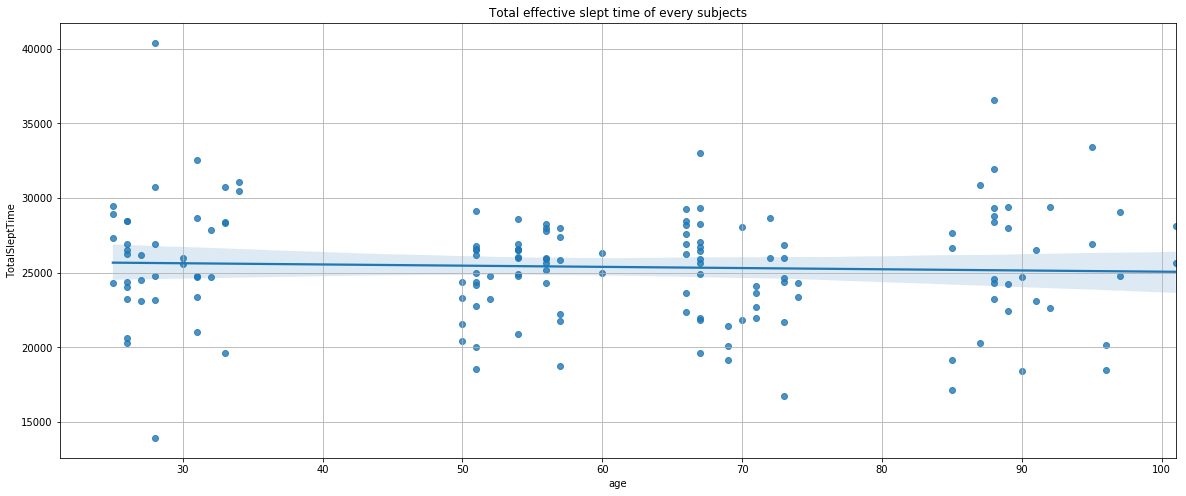

In [81]:
plt.figure(figsize=(20,8))
plt.title('Total effective slept time of every subjects')
plt.grid(True)
regplot(x='age', y='TotalSleptTime', data=df_subject_information)

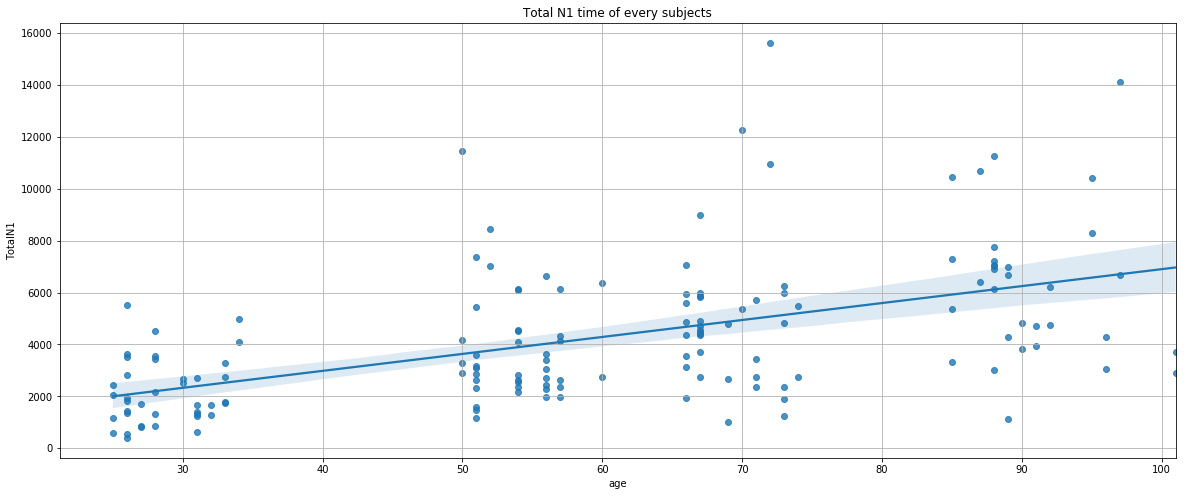

In [82]:
plt.figure(figsize=(20,8))
plt.title('Total N1 time of every subjects')
plt.grid(True)
regplot(x='age', y='TotalN1', data=df_subject_information)

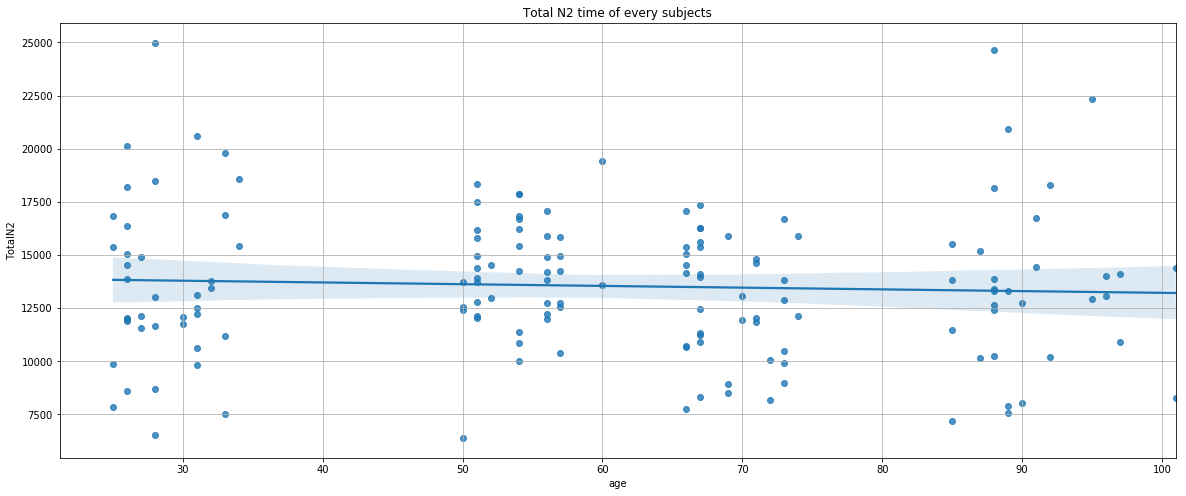

In [83]:
plt.figure(figsize=(20,8))
plt.title('Total N2 time of every subjects')
plt.grid(True)
regplot(x='age', y='TotalN2', data=df_subject_information)

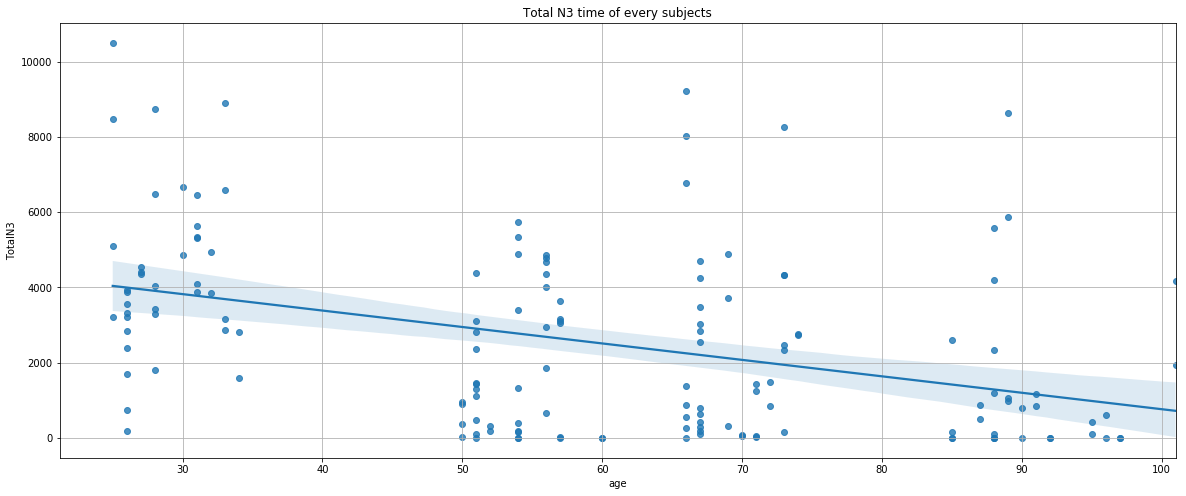

In [84]:
plt.figure(figsize=(20,8))
plt.title('Total N3 time of every subjects')
plt.grid(True)
regplot(x='age', y='TotalN3', data=df_subject_information)

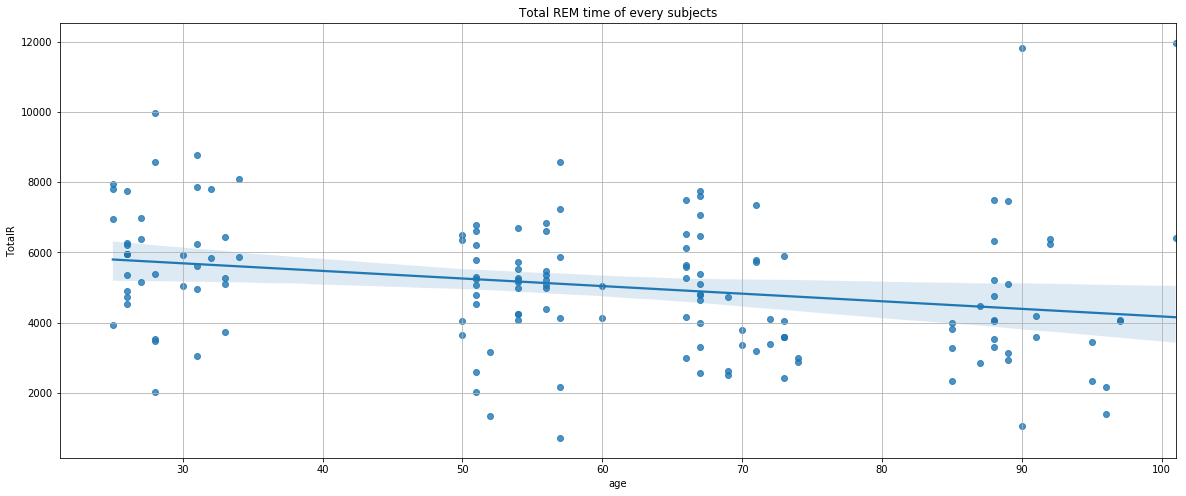

In [85]:
plt.figure(figsize=(20,8))
plt.title('Total REM time of every subjects')
plt.grid(True)
regplot(x='age', y='TotalR', data=df_subject_information)

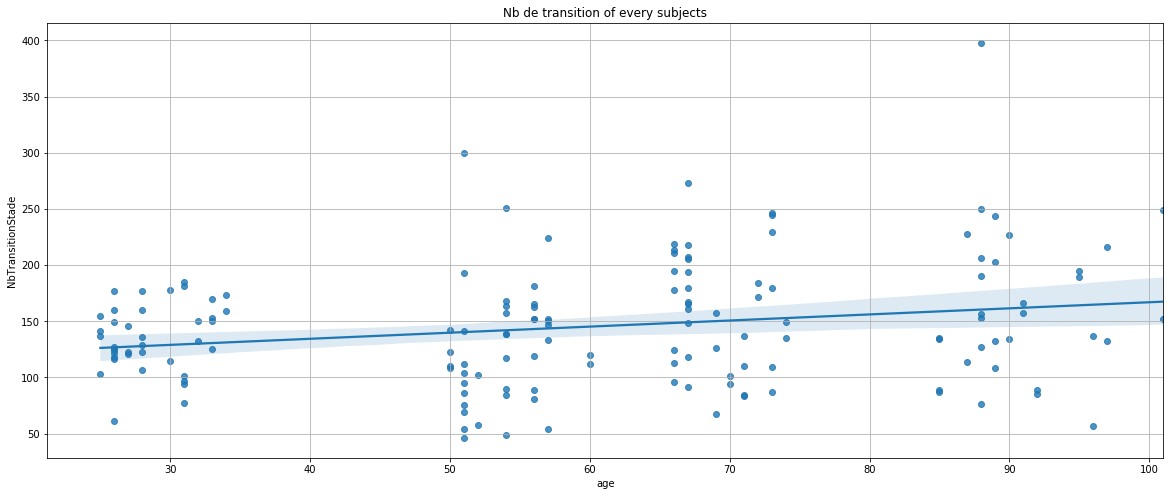

In [86]:
plt.figure(figsize=(20,8))
plt.title('Nb de transition of every subjects')
plt.grid(True)
regplot(x='age', y='NbTransitionStade', data=df_subject_information)

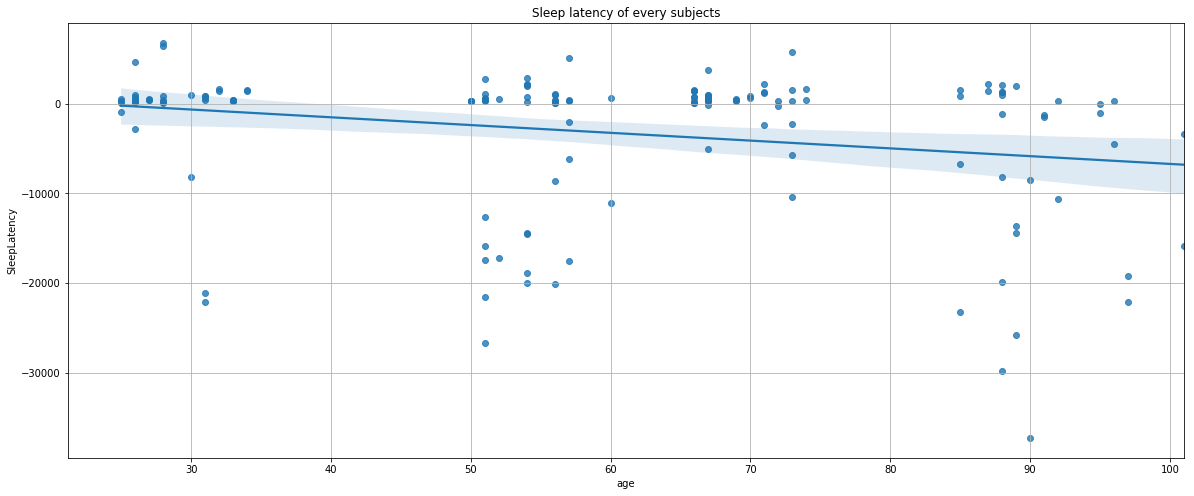

In [87]:
plt.figure(figsize=(20,8))
plt.title('Sleep latency of every subjects')
plt.grid(True)
regplot(x='age', y='SleepLatency', data=df_subject_information)

## Sex
___


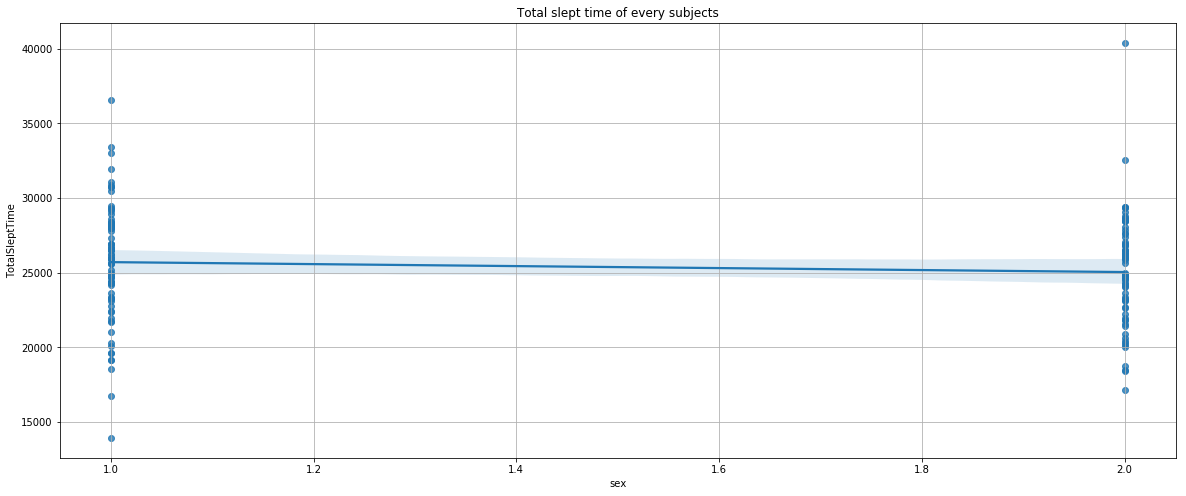

In [88]:
plt.figure(figsize=(20,8))
plt.title('Total slept time of every subjects')
plt.grid(True)
regplot(x='sex', y='TotalSleptTime', data=df_subject_information)

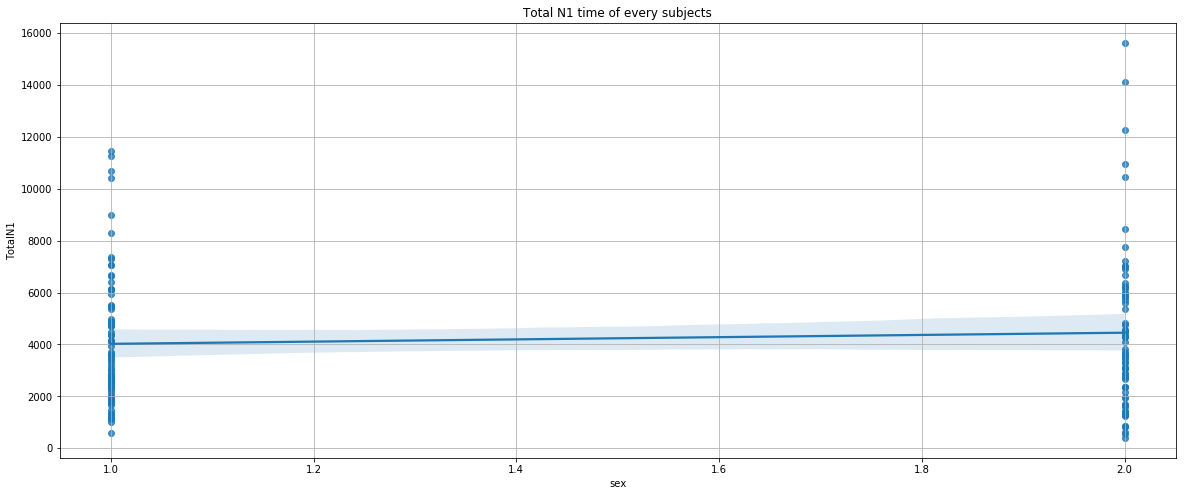

In [89]:
plt.figure(figsize=(20,8))
plt.title('Total N1 time of every subjects')
plt.grid(True)
regplot(x='sex', y='TotalN1', data=df_subject_information)

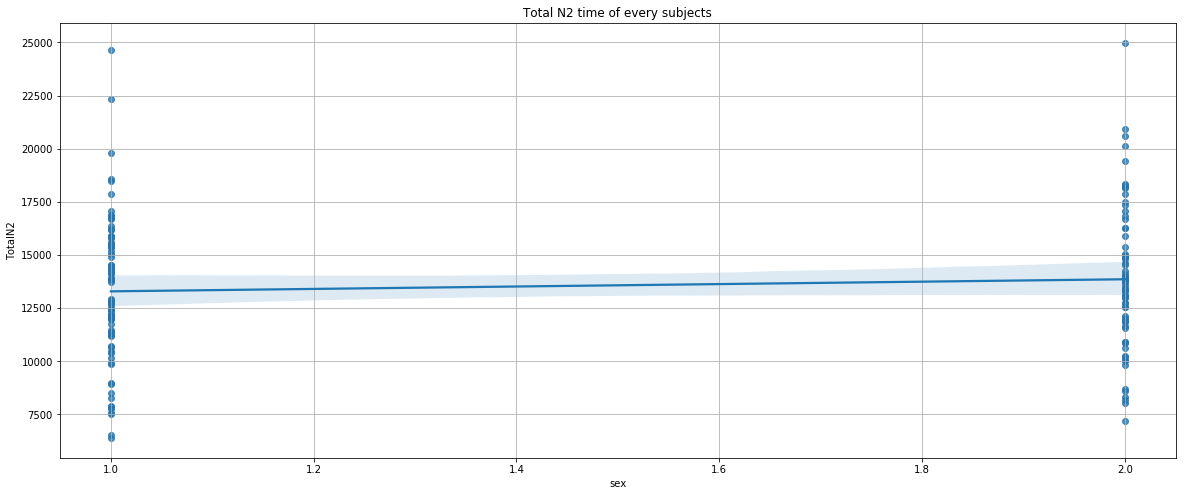

In [90]:
plt.figure(figsize=(20,8))
plt.title('Total N2 time of every subjects')
plt.grid(True)
regplot(x='sex', y='TotalN2', data=df_subject_information)

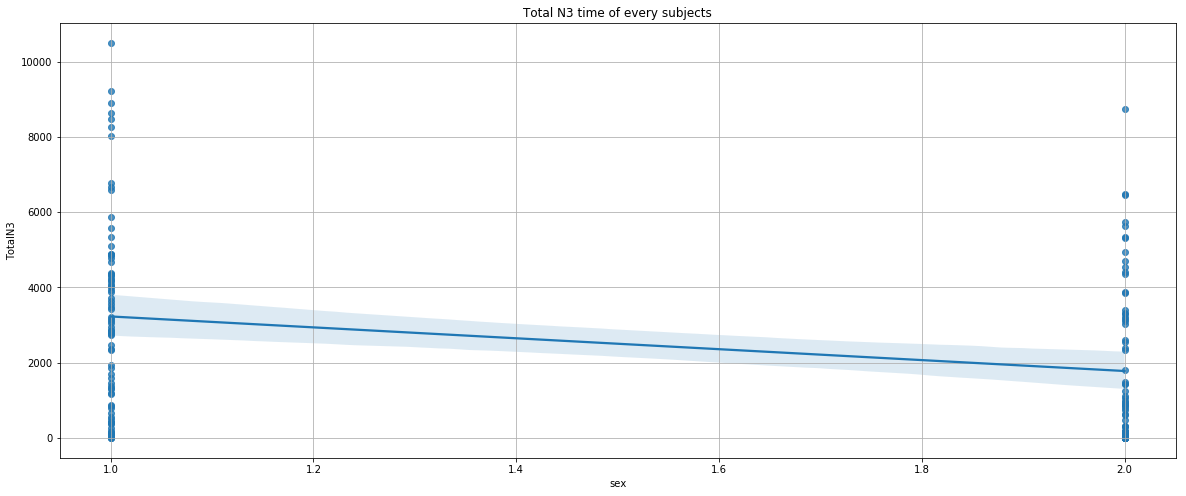

In [91]:
plt.figure(figsize=(20,8))
plt.title('Total N3 time of every subjects')
plt.grid(True)
regplot(x='sex', y='TotalN3', data=df_subject_information)

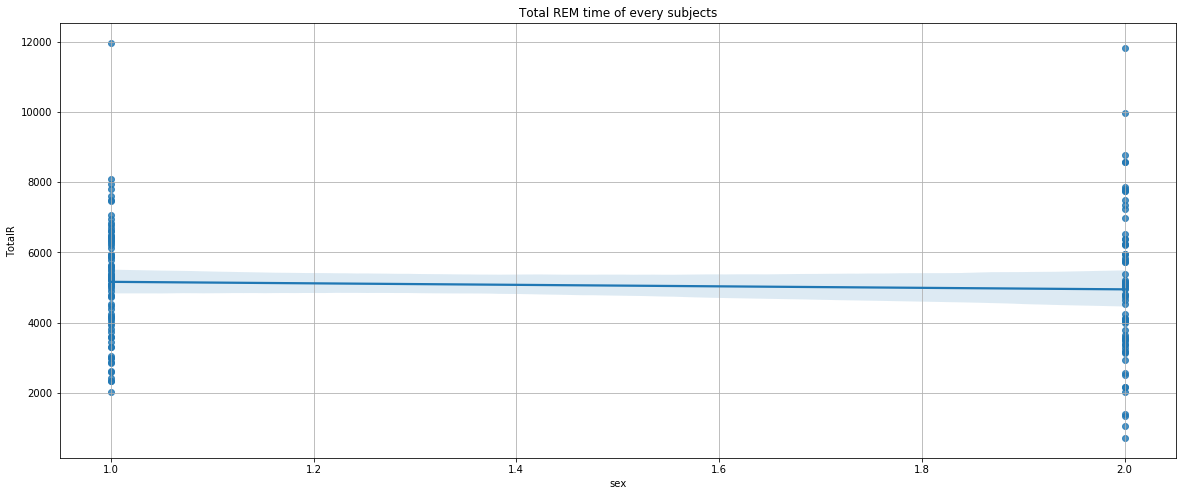

In [92]:
plt.figure(figsize=(20,8))
plt.title('Total REM time of every subjects')
plt.grid(True)
regplot(x='sex', y='TotalR', data=df_subject_information)

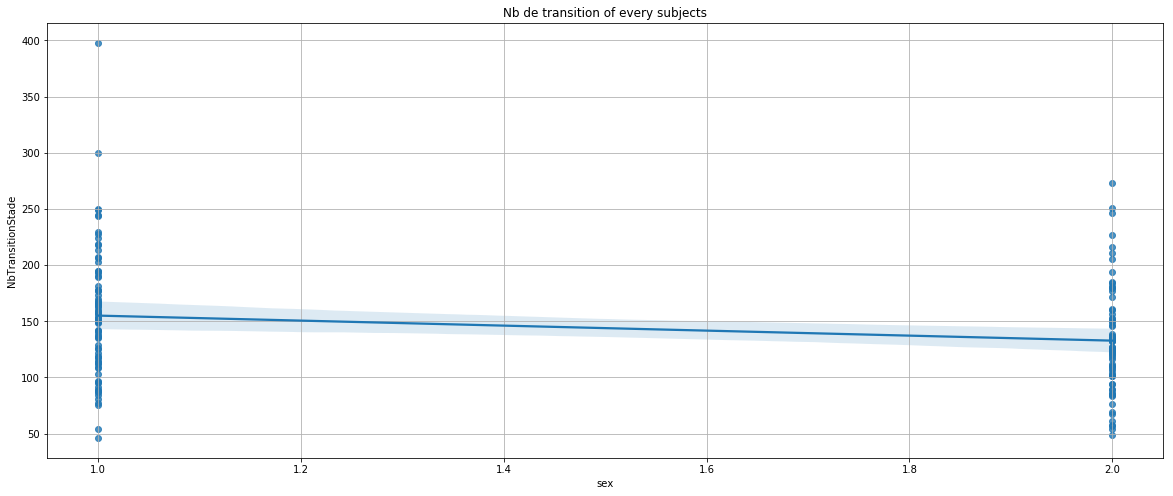

In [93]:
plt.figure(figsize=(20,8))
plt.title('Nb de transition of every subjects')
plt.grid(True)
regplot(x='sex', y='NbTransitionStade', data=df_subject_information)

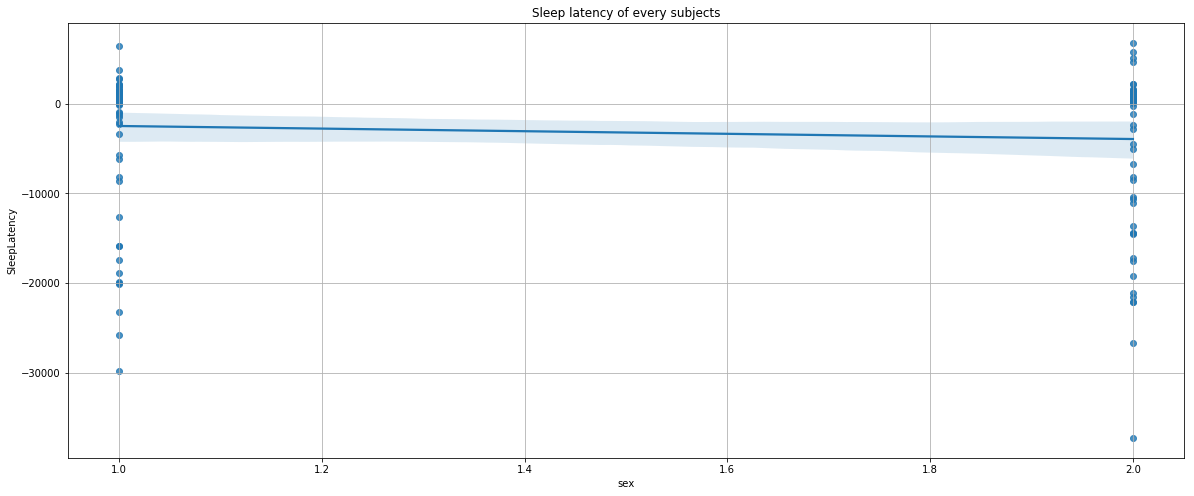

In [94]:
plt.figure(figsize=(20,8))
plt.title('Sleep latency of every subjects')
plt.grid(True)
regplot(x='sex', y='SleepLatency', data=df_subject_information)

### What we see
___

Surely, the gender, but above all, the age could be wonderful features. It looks like it has a great impact on the probability to find a certain stage for a particular subject.

## Conclusion
___

Now that we are more familiar with the data we may build a feature builder pipeline in order to efficiently use CPUs (parrallelism) and the memory. This will enables us to perform a faster feature extraction and also to use all of our dataset (Sleep Cassettes). Also, we searched and tested a couple features that may be interesting. We will surely try the followings as they seems to be able to help us:

- Absolute band frequency
- Relative band frequency
- SEFd
- Standard deviation
- Zero crossing rate
- Hjorth parameters
- Mean energy of each subbands
- Approximate Entropy
- Age of the subject
- Sex of the subject

MMD could have been a nice feature bu we found out it was too CPU intensive. However, we acknowledge that some of the features could have been not correctly implemented and tested by ourselves, but this results still represents a good start for our project.

*For any questions on this notebook, do not hesitate to contact the Polycortex team.*